In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
from tqdm import tqdm
import plotly.express as px
import torch
import clip
from PIL import Image
from sentence_transformers import SentenceTransformer
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import random
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score # Метрика для сравнения кластеров
import umap.umap_ as umap



# Download latest version
#path = kagglehub.dataset_download("promptcloud/amazon-fashion-products-2020")

#print("Path to dataset files:", path)

In [2]:
df = pd.read_json(r"C:\Users\Alex\.cache\kagglehub\datasets\promptcloud\amazon-fashion-products-2020\versions\1\marketing_sample_for_amazon_com-amazon_fashion_products__20200201_20200430__30k_data.ldjson", lines=True)
df

,uniq_id,crawl_timestamp,asin,product_url,product_name,image_urls__small,medium,large,browsenode,brand,...,colour,no__of_reviews,seller_name,seller_id,left_in_stock,no__of_offers,no__of_sellers,technical_details__k_v_pairs,formats___editions,name_of_author_for_books
0,26d41bdc1495de290bc8e6062d927729,2020-02-07 05:11:36 +0000,B07STS2W9T,https://www.amazon.in/Facon-Kalamkari-Handbloc...,LA' Facon Cotton Kalamkari Handblock Saree Blo...,https://images-na.ssl-images-amazon.com/images...,https://images-na.ssl-images-amazon.com/images...,https://images-na.ssl-images-amazon.com/images...,1.968255e+09,LA' Facon,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,410c62298852e68f34c35560f2311e5a,2020-02-07 08:45:56 +0000,B07N6TD2WL,https://www.amazon.in/Sf-Jeans-Pantaloons-T-Sh...,Sf Jeans By Pantaloons Men's Plain Slim fit T-...,https://images-na.ssl-images-amazon.com/images...,https://images-na.ssl-images-amazon.com/images...,https://images-na.ssl-images-amazon.com/images...,1.968123e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,52e31bb31680b0ec73de0d781a23cc0a,2020-02-06 11:09:38 +0000,B07WJ6WPN1,https://www.amazon.in/LOVISTA-Traditional-Prin...,LOVISTA Cotton Gota Patti Tassel Traditional P...,https://images-na.ssl-images-amazon.com/images...,https://images-na.ssl-images-amazon.com/images...,https://images-na.ssl-images-amazon.com/images...,1.968255e+09,LOVISTA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25798d6dc43239c118452d1bee0fb088,2020-02-07 08:32:45 +0000,B07PYSF4WZ,https://www.amazon.in/People-Printed-Regular-T...,People Men's Printed Regular fit T-Shirt,https://images-na.ssl-images-amazon.com/images...,https://images-na.ssl-images-amazon.com/images...,https://images-na.ssl-images-amazon.com/images...,1.968123e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ad8a5a196d515ef09dfdaf082bdc37c4,2020-02-06 14:27:48 +0000,B082KXNM7X,https://www.amazon.in/Monte-Carlo-Cotton-Colla...,Monte Carlo Grey Solid Cotton Blend Polo Colla...,https://images-na.ssl-images-amazon.com/images...,https://images-na.ssl-images-amazon.com/images...,https://images-na.ssl-images-amazon.com/images...,1.968070e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,976b6bda7076509778da69eb3fe0f59c,2020-02-06 23:53:43 +0000,B07FVRMFTX,https://www.amazon.in/Indian-Virasat-Pushp-Cha...,Indian Virasat Women's Rayon Anarkali Kurta,https://images-na.ssl-images-amazon.com/images...,https://images-na.ssl-images-amazon.com/images...,https://images-na.ssl-images-amazon.com/images...,1.968255e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29996,3006a520f71804b055d92216f5dc946d,2020-02-06 20:32:09 +0000,B07RR3XYZD,https://www.amazon.in/Urban-Ranger-Pantaloons-...,Urban Ranger by Pantaloons Men's Slim fit T-Shirt,https://images-na.ssl-images-amazon.com/images...,https://images-na.ssl-images-amazon.com/images...,https://images-na.ssl-images-amazon.com/images...,1.968123e+09,Urban Ranger by Pantaloons,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29997,45ea7c463997f4cd91851617edbfee32,2020-02-06 19:55:44 +0000,B07SSLSR9X,https://www.amazon.in/Peter-England-Striped-Re...,Peter England Men's Regular fit T-Shirt,https://images-na.ssl-images-amazon.com/images...,https://images-na.ssl-images-amazon.com/images...,https://images-na.ssl-images-amazon.com/images...,1.968123e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29998,2ecada524df6ff8c2d0c53a249cfcddc,2020-02-06 05:08:00 +0000,B07P561W67,https://www.amazon.in/PINKY-PARI-Womens-Embroi...,PINKY PARI Women's Embroidered Short Denim Str...,https://images-na.ssl-images-amazon.com/images...,https://images-na.ssl-images-amazon.com/images...,https://images-na.ssl-images-amazon.com/images...,1.968255e+09,PINKY PARI,...,DARK BLUE (BEIGE)|DARK BLUE (RED)|LIGHT BLUE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#выводим названия столбцов
df.columns

Index(['uniq_id', 'crawl_timestamp', 'asin', 'product_url', 'product_name',
       'image_urls__small', 'medium', 'large', 'browsenode', 'brand',
       'sales_price', 'weight', 'rating', 'sales_rank_in_parent_category',
       'sales_rank_in_child_category', 'delivery_type', 'meta_keywords',
       'amazon_prime__y_or_n', 'parent___child_category__all',
       'best_seller_tag__y_or_n', 'other_items_customers_buy',
       'product_details__k_v_pairs', 'discount_percentage', 'colour',
       'no__of_reviews', 'seller_name', 'seller_id', 'left_in_stock',
       'no__of_offers', 'no__of_sellers', 'technical_details__k_v_pairs',
       'formats___editions', 'name_of_author_for_books'],
      dtype='object')

In [3]:
#удаляем строки с пропусками в релевантных столбцах
columns_to_check = ['rating', 'sales_rank_in_child_category', 'medium']

df_cleaned = df.dropna(subset=columns_to_check)

print(f"Общее количество строк ПОСЛЕ очистки: {len(df_cleaned)}")
print(f"Всего удалено строк: {len(df) - len(df_cleaned)}")

Общее количество строк ПОСЛЕ очистки: 24850
Всего удалено строк: 5150


In [4]:
df_cleaned = df_cleaned.reset_index(drop=True)

In [5]:
print(df_cleaned['sales_rank_in_child_category'].apply(type).value_counts())

sales_rank_in_child_category
<class 'dict'>    24850
Name: count, dtype: int64


In [ ]:
#распарсим  столбец sales_rank_in_child_category (ключей может быть несколько

def improved_parser(cell_dict):
   
    if not isinstance(cell_dict, dict) or not cell_dict:
        return None, None

    try:
      
        if len(cell_dict) > 1 and 'Fashion' in cell_dict:
         
            filtered_dict = {k: v for k, v in cell_dict.items() if k != 'Fashion'}
            category = list(filtered_dict.keys())[0]
            rank_str = list(filtered_dict.values())[0]

        else:
            
            category = list(cell_dict.keys())[0]
            rank_str = list(cell_dict.values())[0]

        if isinstance(rank_str, str):
            cleaned_rank_str = rank_str.lstrip('#')
        else:
            cleaned_rank_str = str(rank_str)
        
        numeric_part = ''.join(filter(str.isdigit, cleaned_rank_str))
        
        rank_int = int(numeric_part) if numeric_part else None

        return category, rank_int

    except (IndexError, TypeError, ValueError):
        
        return None, None

parsed_data = df_cleaned['sales_rank_in_child_category'].apply(improved_parser)
df_cleaned[['category', 'rank']] = pd.DataFrame(parsed_data.tolist(), index=df_cleaned.index)

In [ ]:
# скачиваем изображения
IMAGE_DIR = "image"

os.makedirs(IMAGE_DIR, exist_ok=True)
print(f"Изображения будут сохранены в папку: '{IMAGE_DIR}/'")

df_download = df_cleaned.dropna(subset=['uniq_id', 'medium']).copy()

df_download = df_download[df_download['medium'] != '']
print(f"Найдено {len(df_download)} изображений для скачивания.")

for index, row in tqdm(df_download.iterrows(), total=len(df_download), desc="Скачивание изображений"):
    uniq_id = row['uniq_id']
    image_url = row['medium']

    try:
        file_extension = os.path.splitext(image_url)[1]
        if not file_extension:
            file_extension = ".jpg"
            
        filename = f"{uniq_id}{file_extension}"
        filepath = os.path.join(IMAGE_DIR, filename)

       
        if not os.path.exists(filepath):
          
            response = requests.get(image_url, stream=True, timeout=15)
            
            response.raise_for_status()

            with open(filepath, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
    
    except requests.exceptions.RequestException as e:
      
        print(f"\nОшибка при скачивании {image_url} для uniq_id {uniq_id}. Ошибка: {e}")
    except Exception as e:
       
        print(f"\nПроизошла непредвиденная ошибка для uniq_id {uniq_id}. Ошибка: {e}")

print("\nСкачивание завершено!")

Изображения будут сохранены в папку: 'image/'
Найдено 24850 изображений для скачивания.
Начинаем скачивание...


Скачивание изображений:   0%|          | 85/24850 [00:17<4:06:48,  1.67it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41y6JV0jlTL.jpg|https://images-na.ssl-images-amazon.com/images/I/412UdG6PPXL.jpg для uniq_id 83040ced85dab8b251020f21c991fc29. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41y6JV0jlTL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/412UdG6PPXL.jpg


Скачивание изображений:   0%|          | 95/24850 [00:21<3:06:53,  2.21it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41gHp06h%2BjL.jpg|https://images-na.ssl-images-amazon.com/images/I/41ByWjxI-UL.jpg|https://images-na.ssl-images-amazon.com/images/I/41CyWcxz%2BIL.jpg|https://images-na.ssl-images-amazon.com/images/I/41E7HBW-TNL.jpg|https://images-na.ssl-images-amazon.com/images/I/41ozPVF%2BbqL.jpg|https://images-na.ssl-images-amazon.com/images/I/41aqwn7NvfL.jpg|https://images-na.ssl-images-amazon.com/images/I/314AfMbcxVL.jpg для uniq_id cc14a590451945f5b33615bb0ba1b987. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41gHp06h%2BjL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41ByWjxI-UL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41CyWcxz%2BIL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41E7HBW-TNL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41ozPVF%2BbqL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41aqwn7NvfL.jpg%7Chttps://images-na

Скачивание изображений:   1%|          | 196/24850 [00:54<4:48:43,  1.42it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41OwqIVlGrL.jpg|https://images-na.ssl-images-amazon.com/images/I/41KeKIK2x9L.jpg для uniq_id 733c18e4bf01e3876447c64932123b77. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41OwqIVlGrL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41KeKIK2x9L.jpg


Скачивание изображений:   3%|▎         | 745/24850 [03:57<2:56:27,  2.28it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/51wWgsS2u%2BL.jpg|https://images-na.ssl-images-amazon.com/images/I/51sPRW4NSEL.jpg для uniq_id de419b7b04875d1a553d66c0747318b8. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/51wWgsS2u%2BL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/51sPRW4NSEL.jpg


Скачивание изображений:   8%|▊         | 1949/24850 [10:49<2:50:52,  2.23it/s] 


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/51LO6uiy-HL.jpg|https://images-na.ssl-images-amazon.com/images/I/51f7qK0ruML.jpg для uniq_id cf911e8657a2478373b7134c8eeb8b59. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/51LO6uiy-HL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/51f7qK0ruML.jpg


Скачивание изображений:   9%|▉         | 2252/24850 [12:40<2:33:55,  2.45it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41Soyb401DL.jpg|https://images-na.ssl-images-amazon.com/images/I/412Ba3KSH8L.jpg для uniq_id 5e5f3c64f5e9e68d2bfaa9fa7d61f0b9. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41Soyb401DL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/412Ba3KSH8L.jpg


Скачивание изображений:  12%|█▏        | 2953/24850 [16:32<2:26:52,  2.48it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41-oTTKqhTL.jpg|https://images-na.ssl-images-amazon.com/images/I/414ALiFeQwL.jpg для uniq_id 387a8fb8c1f96e4c425672c1a957d0a6. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41-oTTKqhTL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/414ALiFeQwL.jpg


Скачивание изображений:  13%|█▎        | 3108/24850 [17:31<2:49:27,  2.14it/s] 


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41S1aHgH3tL.jpg|https://images-na.ssl-images-amazon.com/images/I/41xCIifx7nL.jpg для uniq_id 3ca5333a2d463afbbc37c5479635f138. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41S1aHgH3tL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41xCIifx7nL.jpg


Скачивание изображений:  14%|█▎        | 3399/24850 [19:19<3:02:16,  1.96it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/516o9SzUX7L.jpg|https://images-na.ssl-images-amazon.com/images/I/51sywd%2BJx0L.jpg для uniq_id 98d85ac311a865483b17e33b41f0ea09. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/516o9SzUX7L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/51sywd%2BJx0L.jpg


Скачивание изображений:  14%|█▍        | 3528/24850 [20:02<2:24:59,  2.45it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41nh9ZKL%2B6L.jpg|https://images-na.ssl-images-amazon.com/images/I/41CgzrlGArL.jpg|https://images-na.ssl-images-amazon.com/images/I/31jETnvpb9L.jpg|https://images-na.ssl-images-amazon.com/images/I/41-teQ6DxlL.jpg|https://images-na.ssl-images-amazon.com/images/I/31DNpV30zlL.jpg|https://images-na.ssl-images-amazon.com/images/I/41q-1vjXQ4L.jpg|https://images-na.ssl-images-amazon.com/images/I/415ycedCh5L.jpg|https://images-na.ssl-images-amazon.com/images/I/31zrJ2dhm4L.jpg для uniq_id 9e3a2b726f2f4a234742e1f6fb0fc2d6. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41nh9ZKL%2B6L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41CgzrlGArL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31jETnvpb9L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41-teQ6DxlL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31DNpV30zlL.jpg%7Chttps://images-na.ssl-image

Скачивание изображений:  15%|█▍        | 3647/24850 [20:45<2:50:47,  2.07it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/51SFLyLgaaL.jpg|https://images-na.ssl-images-amazon.com/images/I/51xukAwszHL.jpg для uniq_id c1c971e74ad7ae79e43efc3ef924d653. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/51SFLyLgaaL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/51xukAwszHL.jpg


Скачивание изображений:  16%|█▌        | 3921/24850 [22:20<2:36:30,  2.23it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41GLHCIvQKL.jpg|https://images-na.ssl-images-amazon.com/images/I/41ONJQXtPWL.jpg для uniq_id c24d094491a6ffbdef0cdfe50b071e87. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41GLHCIvQKL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41ONJQXtPWL.jpg


Скачивание изображений:  16%|█▌        | 3981/24850 [22:42<2:38:01,  2.20it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/31RZA5I%2BTiL.jpg|https://images-na.ssl-images-amazon.com/images/I/31vBRfq40eL.jpg|https://images-na.ssl-images-amazon.com/images/I/31gvF1iA10L.jpg|https://images-na.ssl-images-amazon.com/images/I/31yjYWZtkfL.jpg|https://images-na.ssl-images-amazon.com/images/I/418HEFbUiFL.jpg|https://images-na.ssl-images-amazon.com/images/I/41JBkWs4fTL.jpg для uniq_id 4dd8492c81a94ea8884116bcd2fe87f3. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/31RZA5I%2BTiL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31vBRfq40eL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31gvF1iA10L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31yjYWZtkfL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/418HEFbUiFL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41JBkWs4fTL.jpg


Скачивание изображений:  19%|█▉        | 4749/24850 [26:56<2:33:35,  2.18it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/418d%2BeZXAPL.jpg|https://images-na.ssl-images-amazon.com/images/I/412AgCMaGAL.jpg|https://images-na.ssl-images-amazon.com/images/I/41MFswFo0SL.jpg|https://images-na.ssl-images-amazon.com/images/I/41OdseilL6L.jpg для uniq_id b1e5e39b5afb21637771d8c16edd005a. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/418d%2BeZXAPL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/412AgCMaGAL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41MFswFo0SL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41OdseilL6L.jpg


Скачивание изображений:  23%|██▎       | 5620/24850 [31:46<2:06:01,  2.54it/s] 


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/31DLuKdZlmL.jpg|https://images-na.ssl-images-amazon.com/images/I/31U-CwTqI9L.jpg|https://images-na.ssl-images-amazon.com/images/I/41KbaxBcELL.jpg|https://images-na.ssl-images-amazon.com/images/I/31EEncvolDL.jpg|https://images-na.ssl-images-amazon.com/images/I/31GnaHlOvaL.jpg|https://images-na.ssl-images-amazon.com/images/I/31orJV3fVsL.jpg|https://images-na.ssl-images-amazon.com/images/I/113kil0xbRL.jpg|https://images-na.ssl-images-amazon.com/images/I/51VAYNZ-6%2BL.jpg для uniq_id 5047dc6bfc7a04225f0c2d597c6b4cbc. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/31DLuKdZlmL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31U-CwTqI9L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41KbaxBcELL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31EEncvolDL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31GnaHlOvaL.jpg%7Chttps://images-na.ssl-images-

Скачивание изображений:  26%|██▌       | 6430/24850 [36:21<2:11:16,  2.34it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41g8D0NiY7L.jpg|https://images-na.ssl-images-amazon.com/images/I/41shykZ2W-L.jpg для uniq_id 9d3427c14c2d7baf4bc59197c4059279. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41g8D0NiY7L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41shykZ2W-L.jpg


Скачивание изображений:  28%|██▊       | 6913/24850 [39:18<2:01:31,  2.46it/s] 


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/51qI7z3J4mL.jpg|https://images-na.ssl-images-amazon.com/images/I/51IpTSGZGrL.jpg для uniq_id 02c03f571a03cbbe6253f87a5f6ecd0a. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/51qI7z3J4mL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/51IpTSGZGrL.jpg


Скачивание изображений:  31%|███       | 7681/24850 [45:05<2:00:51,  2.37it/s] 


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41yNbj%2BW2bL.jpg|https://images-na.ssl-images-amazon.com/images/I/41EefanvVAL.jpg для uniq_id 419fba81758f2ab54d4ac9690480f28d. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41yNbj%2BW2bL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41EefanvVAL.jpg


Скачивание изображений:  31%|███▏      | 7823/24850 [45:51<1:58:06,  2.40it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41pimnr9puL.jpg|https://images-na.ssl-images-amazon.com/images/I/41V03tnIb1L.jpg для uniq_id 409024ac25e5cb5daf011e89e27fbdb2. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41pimnr9puL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41V03tnIb1L.jpg


Скачивание изображений:  32%|███▏      | 7961/24850 [46:37<1:54:19,  2.46it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41LNInzSKGL.jpg|https://images-na.ssl-images-amazon.com/images/I/41hoWXZ%2BkTL.jpg для uniq_id 0eecc703dc156b235e840df886b217cc. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41LNInzSKGL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41hoWXZ%2BkTL.jpg


Скачивание изображений:  33%|███▎      | 8291/24850 [48:43<1:53:24,  2.43it/s] 


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41AoNPel96L.jpg|https://images-na.ssl-images-amazon.com/images/I/41HKgvKfCpL.jpg|https://images-na.ssl-images-amazon.com/images/I/317MXy3i2QL.jpg|https://images-na.ssl-images-amazon.com/images/I/51-qEbC3VxL.jpg|https://images-na.ssl-images-amazon.com/images/I/511N-VXzvmL.jpg|https://images-na.ssl-images-amazon.com/images/I/31ydLsiU9IL.jpg для uniq_id dbcee31446474ea36185a6a5165875a0. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41AoNPel96L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41HKgvKfCpL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/317MXy3i2QL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/51-qEbC3VxL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/511N-VXzvmL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31ydLsiU9IL.jpg


Скачивание изображений:  34%|███▍      | 8427/24850 [49:32<2:26:31,  1.87it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41Rzrb9Ac5L.jpg|https://images-na.ssl-images-amazon.com/images/I/41pxjs-EIML.jpg для uniq_id 4443bb4aaf1e5af3ca0e21a510db830b. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41Rzrb9Ac5L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41pxjs-EIML.jpg


Скачивание изображений:  34%|███▍      | 8537/24850 [50:08<2:03:12,  2.21it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41YhmsHQh6L.jpg|https://images-na.ssl-images-amazon.com/images/I/31OWj8ADcPL.jpg для uniq_id 454308e11c4ace20365fc170a3e7f471. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41YhmsHQh6L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31OWj8ADcPL.jpg


Скачивание изображений:  36%|███▌      | 8853/24850 [52:04<1:43:13,  2.58it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41TRYN8190L.jpg|https://images-na.ssl-images-amazon.com/images/I/41U7VQsTS3L.jpg|https://images-na.ssl-images-amazon.com/images/I/41IeQude5TL.jpg|https://images-na.ssl-images-amazon.com/images/I/41TfesM0b5L.jpg|https://images-na.ssl-images-amazon.com/images/I/31KCpbJ-rWL.jpg для uniq_id e84e432b8354533f7c1b06b2a0d37021. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41TRYN8190L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41U7VQsTS3L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41IeQude5TL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41TfesM0b5L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31KCpbJ-rWL.jpg


Скачивание изображений:  39%|███▊      | 9623/24850 [56:31<1:40:42,  2.52it/s] 


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/31qJYtSMfvL.jpg|https://images-na.ssl-images-amazon.com/images/I/31uvQV8FOQL.jpg для uniq_id 5562c0b21e8c709a45f2098cbc6f625b. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/31qJYtSMfvL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31uvQV8FOQL.jpg


Скачивание изображений:  40%|███▉      | 9830/24850 [57:37<1:26:32,  2.89it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/414Mnkc3ZLL.jpg|https://images-na.ssl-images-amazon.com/images/I/41AhT6RcYwL.jpg для uniq_id 82af00429ea7d096378572c9eb5e111f. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/414Mnkc3ZLL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41AhT6RcYwL.jpg


Скачивание изображений:  40%|████      | 10015/24850 [58:38<1:41:57,  2.43it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41ZsTJFc2gL.jpg|https://images-na.ssl-images-amazon.com/images/I/41DpXBTRsrL.jpg для uniq_id c898b61090b7e6c67d8d650ad7c3d3c2. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41ZsTJFc2gL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41DpXBTRsrL.jpg


Скачивание изображений:  44%|████▎     | 10858/24850 [1:03:23<1:50:19,  2.11it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41XdFgXacGL.jpg|https://images-na.ssl-images-amazon.com/images/I/41O7C1CdI9L.jpg для uniq_id 3fc673da08d66f5bc62cb25f555b1328. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41XdFgXacGL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41O7C1CdI9L.jpg


Скачивание изображений:  44%|████▍     | 10890/24850 [1:03:35<1:34:51,  2.45it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41Qj-zlEqeL.jpg|https://images-na.ssl-images-amazon.com/images/I/41RavefuadL.jpg для uniq_id 2998128e6877dd3fc96fa203ca63dabb. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41Qj-zlEqeL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41RavefuadL.jpg


Скачивание изображений:  45%|████▍     | 11180/24850 [1:05:16<1:53:25,  2.01it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41VNsDi9mvL.jpg|https://images-na.ssl-images-amazon.com/images/I/41iKu7oxMZL.jpg для uniq_id db9e4b519b867be0bede406ccc956761. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41VNsDi9mvL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41iKu7oxMZL.jpg


Скачивание изображений:  46%|████▌     | 11417/24850 [1:06:39<1:33:37,  2.39it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41qlb2jKKKL.jpg|https://images-na.ssl-images-amazon.com/images/I/4168bbeEOcL.jpg|https://images-na.ssl-images-amazon.com/images/I/31sSAMtUaZL.jpg|https://images-na.ssl-images-amazon.com/images/I/41gIAmiS82L.jpg|https://images-na.ssl-images-amazon.com/images/I/41vIU%2BAHlPL.jpg|https://images-na.ssl-images-amazon.com/images/I/618OfZyY%2BNL.jpg|https://images-na.ssl-images-amazon.com/images/I/6112z0Ok%2BgL.jpg для uniq_id 67cc30c77c58d20309df240fb269aa1f. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41qlb2jKKKL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/4168bbeEOcL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31sSAMtUaZL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41gIAmiS82L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41vIU%2BAHlPL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/618OfZyY%2BNL.jpg%7Chttps://images-na.s

Скачивание изображений:  50%|████▉     | 12386/24850 [1:13:24<1:40:44,  2.06it/s] 


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41Oyl3PkWZL.jpg|https://images-na.ssl-images-amazon.com/images/I/31Qjgoc1pOL.jpg|https://images-na.ssl-images-amazon.com/images/I/41Y6VwBlCkL.jpg|https://images-na.ssl-images-amazon.com/images/I/31wJtiYODSL.jpg|https://images-na.ssl-images-amazon.com/images/I/41%2BfkCutC9L.jpg для uniq_id d5a4284dc00d702d287a38ab39572016. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41Oyl3PkWZL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31Qjgoc1pOL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41Y6VwBlCkL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31wJtiYODSL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41%2BfkCutC9L.jpg


Скачивание изображений:  51%|█████▏    | 12738/24850 [1:15:54<1:21:24,  2.48it/s] 


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41YRtI6%2BK5L.jpg|https://images-na.ssl-images-amazon.com/images/I/41M9DSgd%2BzL.jpg|https://images-na.ssl-images-amazon.com/images/I/316W-knpFaL.jpg|https://images-na.ssl-images-amazon.com/images/I/31AfY%2BQn7KL.jpg|https://images-na.ssl-images-amazon.com/images/I/41fq6Qh7o%2BL.jpg для uniq_id 8fc0856a16f2f634042de67a4d9ce858. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41YRtI6%2BK5L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41M9DSgd%2BzL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/316W-knpFaL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31AfY%2BQn7KL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41fq6Qh7o%2BL.jpg


Скачивание изображений:  52%|█████▏    | 12816/24850 [1:16:21<1:21:19,  2.47it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/415TPmetNAL.jpg|https://images-na.ssl-images-amazon.com/images/I/41SttpZJvSL.jpg для uniq_id d89bf19d1391bcee362d570687ec78ec. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/415TPmetNAL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41SttpZJvSL.jpg


Скачивание изображений:  52%|█████▏    | 12909/24850 [1:16:54<1:20:12,  2.48it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/514ZO-sTH7L.jpg|https://images-na.ssl-images-amazon.com/images/I/51YoxNWda4L.jpg для uniq_id bcc0501b40586a06522091359469e937. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/514ZO-sTH7L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/51YoxNWda4L.jpg


Скачивание изображений:  52%|█████▏    | 12933/24850 [1:17:01<1:02:53,  3.16it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/510V9rElKhL.jpg|https://images-na.ssl-images-amazon.com/images/I/51jBhz9Nm-L.jpg для uniq_id 3355968595eec15f8d5b790174a45b9f. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/510V9rElKhL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/51jBhz9Nm-L.jpg


Скачивание изображений:  52%|█████▏    | 13030/24850 [1:17:41<1:28:03,  2.24it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41p8smPIbGL.jpg|https://images-na.ssl-images-amazon.com/images/I/41Hail53uUL.jpg для uniq_id 3f9a842c3b8b72db5972bf3c7e5c0c2d. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41p8smPIbGL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41Hail53uUL.jpg


Скачивание изображений:  55%|█████▍    | 13557/24850 [1:21:11<2:16:38,  1.38it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41QxhRBoS5L.jpg|https://images-na.ssl-images-amazon.com/images/I/41QIUlvMz7L.jpg для uniq_id 53ccf278a5099d181eff8f7860bc19c2. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41QxhRBoS5L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41QIUlvMz7L.jpg


Скачивание изображений:  58%|█████▊    | 14397/24850 [1:27:15<1:07:56,  2.56it/s] 


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41lHFHQBgaL.jpg|https://images-na.ssl-images-amazon.com/images/I/417jlxyRMxL.jpg для uniq_id 5a3f6743b14715542ed176d7a755ec32. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41lHFHQBgaL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/417jlxyRMxL.jpg


Скачивание изображений:  60%|██████    | 14992/24850 [1:31:07<51:52,  3.17it/s]  


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41-rID539-L.jpg|https://images-na.ssl-images-amazon.com/images/I/41x5RXOtSwL.jpg для uniq_id 4a576fa41891113643cb8fd460ff22f7. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41-rID539-L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41x5RXOtSwL.jpg


Скачивание изображений:  61%|██████    | 15091/24850 [1:32:07<1:06:54,  2.43it/s] 


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/31nQcyeFNPL.jpg|https://images-na.ssl-images-amazon.com/images/I/31b6QJog9gL.jpg для uniq_id 4ac5668237c3c961f5ccb38bdd41f6be. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/31nQcyeFNPL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31b6QJog9gL.jpg


Скачивание изображений:  64%|██████▍   | 15920/24850 [1:37:38<12:01:37,  4.85s/it]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/51CfatPm48L.jpg|https://images-na.ssl-images-amazon.com/images/I/517YKFksQTL.jpg|https://images-na.ssl-images-amazon.com/images/I/61rUhKJaqhL.jpg для uniq_id fc67e1a44f0b2f3a60b59b3035e6edd9. Ошибка: HTTPSConnectionPool(host='images-na.ssl-images-amazon.com', port=443): Read timed out. (read timeout=15)


Скачивание изображений:  64%|██████▍   | 15980/24850 [1:38:00<1:07:16,  2.20it/s] 


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41vsyJCj17L.jpg|https://images-na.ssl-images-amazon.com/images/I/41AxGB%2BoRSL.jpg для uniq_id 42320100ab366a4d41a9829df3436f1b. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41vsyJCj17L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41AxGB%2BoRSL.jpg


Скачивание изображений:  66%|██████▋   | 16508/24850 [1:41:20<1:00:42,  2.29it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41YiqjUN%2B2L.jpg|https://images-na.ssl-images-amazon.com/images/I/41m4nQeazlL.jpg|https://images-na.ssl-images-amazon.com/images/I/31zqJK-P7AL.jpg|https://images-na.ssl-images-amazon.com/images/I/41CEFgFU-eL.jpg|https://images-na.ssl-images-amazon.com/images/I/319trSsIjBL.jpg|https://images-na.ssl-images-amazon.com/images/I/417aNx40%2B8L.jpg для uniq_id a4eab63cb3a70409c947ecaf1212efd6. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41YiqjUN%2B2L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41m4nQeazlL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31zqJK-P7AL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41CEFgFU-eL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/319trSsIjBL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/417aNx40%2B8L.jpg


Скачивание изображений:  67%|██████▋   | 16694/24850 [1:43:22<1:16:08,  1.79it/s] 


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41a-UqHP7FL.jpg|https://images-na.ssl-images-amazon.com/images/I/31seTxnszDL.jpg|https://images-na.ssl-images-amazon.com/images/I/31JLtVoA09L.jpg|https://images-na.ssl-images-amazon.com/images/I/41WOmCJcFlL.jpg|https://images-na.ssl-images-amazon.com/images/I/417fFyMdCTL.jpg для uniq_id 8d1d379efa883e052f04e99e11edc320. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41a-UqHP7FL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31seTxnszDL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31JLtVoA09L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41WOmCJcFlL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/417fFyMdCTL.jpg


Скачивание изображений:  68%|██████▊   | 17006/24850 [1:45:10<54:14,  2.41it/s]  


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/31B%2BLVT3IbL.jpg|https://images-na.ssl-images-amazon.com/images/I/31Sn2NMFUdL.jpg|https://images-na.ssl-images-amazon.com/images/I/41VtGDiYz5L.jpg|https://images-na.ssl-images-amazon.com/images/I/31EhzuogQzL.jpg|https://images-na.ssl-images-amazon.com/images/I/31lAFEq6J2L.jpg|https://images-na.ssl-images-amazon.com/images/I/31UG356IJML.jpg|https://images-na.ssl-images-amazon.com/images/I/31yr78Ij8-L.jpg|https://images-na.ssl-images-amazon.com/images/I/3198CiFV8-L.jpg|https://images-na.ssl-images-amazon.com/images/I/417nW8Kz0VL.jpg для uniq_id d9e97929db0bffe136b16264ba360150. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/31B%2BLVT3IbL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31Sn2NMFUdL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41VtGDiYz5L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31EhzuogQzL.jpg%7Chttps://images-na.ssl-images-

Скачивание изображений:  69%|██████▊   | 17040/24850 [1:45:36<10:18:55,  4.75s/it]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41VG2GSd3gL.jpg|https://images-na.ssl-images-amazon.com/images/I/41JYCBt4%2BWL.jpg|https://images-na.ssl-images-amazon.com/images/I/31sQ3Z6l9-L.jpg|https://images-na.ssl-images-amazon.com/images/I/414P-wmxfvL.jpg|https://images-na.ssl-images-amazon.com/images/I/51LizzDEpzL.jpg для uniq_id 866a1b925e566a61e1a9dc3a3e987827. Ошибка: HTTPSConnectionPool(host='images-na.ssl-images-amazon.com', port=443): Read timed out. (read timeout=15)


Скачивание изображений:  71%|███████   | 17540/24850 [1:48:26<1:21:30,  1.49it/s] 


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/51Dp5JoyoJL.jpg|https://images-na.ssl-images-amazon.com/images/I/51ewT-RdHNL.jpg для uniq_id 6ad6ba81832e14875a5e044739fff9a3. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/51Dp5JoyoJL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/51ewT-RdHNL.jpg


Скачивание изображений:  71%|███████   | 17632/24850 [1:49:05<1:24:35,  1.42it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41XpMWYxPRL.jpg|https://images-na.ssl-images-amazon.com/images/I/41YtVc5dw0L.jpg|https://images-na.ssl-images-amazon.com/images/I/51JDn594UWL.jpg|https://images-na.ssl-images-amazon.com/images/I/41fq6Qh7o%2BL.jpg для uniq_id 8549607030abf894e2a044c3e9d68ff8. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41XpMWYxPRL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41YtVc5dw0L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/51JDn594UWL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41fq6Qh7o%2BL.jpg


Скачивание изображений:  73%|███████▎  | 18141/24850 [1:52:59<48:29,  2.31it/s]  


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41SJnYTrFrL.jpg|https://images-na.ssl-images-amazon.com/images/I/41DsFmCUALL.jpg для uniq_id f3c153126f5f9e38b6d60814b29215c6. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41SJnYTrFrL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41DsFmCUALL.jpg


Скачивание изображений:  73%|███████▎  | 18209/24850 [1:53:26<47:16,  2.34it/s]  


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/4174RJrdGLL.jpg|https://images-na.ssl-images-amazon.com/images/I/41QKjN6oVoL.jpg для uniq_id cf07081544f7f0427f2ae4dec4e4247e. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/4174RJrdGLL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41QKjN6oVoL.jpg


Скачивание изображений:  77%|███████▋  | 19146/24850 [1:59:18<44:19,  2.14it/s]  


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41ELI0-BRuL.jpg|https://images-na.ssl-images-amazon.com/images/I/41hwVE9wn4L.jpg|https://images-na.ssl-images-amazon.com/images/I/51cZV5yDupL.jpg|https://images-na.ssl-images-amazon.com/images/I/41gkxyiA1gL.jpg для uniq_id 88b3625464748433287e98dc6e94feb1. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41ELI0-BRuL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41hwVE9wn4L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/51cZV5yDupL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41gkxyiA1gL.jpg


Скачивание изображений:  77%|███████▋  | 19222/24850 [1:59:44<42:14,  2.22it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/31XSmlOakPL.jpg|https://images-na.ssl-images-amazon.com/images/I/31BB3h6FJTL.jpg для uniq_id fcf33684e1b6f96433cc07a189ce707e. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/31XSmlOakPL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31BB3h6FJTL.jpg


Скачивание изображений:  79%|███████▉  | 19647/24850 [2:02:12<38:25,  2.26it/s]  


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/418754%2BBAoL.jpg|https://images-na.ssl-images-amazon.com/images/I/415UbUkh7kL.jpg|https://images-na.ssl-images-amazon.com/images/I/51tzSA4p1AL.jpg|https://images-na.ssl-images-amazon.com/images/I/51CqIXnEktL.jpg|https://images-na.ssl-images-amazon.com/images/I/31hsUAfFvvL.jpg|https://images-na.ssl-images-amazon.com/images/I/41kNjpNH-BL.jpg|https://images-na.ssl-images-amazon.com/images/I/419z6Uo1wOL.jpg|https://images-na.ssl-images-amazon.com/images/I/31hiun52njL.jpg|https://images-na.ssl-images-amazon.com/images/I/41r8X7rXObL.jpg|https://images-na.ssl-images-amazon.com/images/I/418Mc515vmL.jpg для uniq_id 9d134be7637270cd2cb57bb770d6c81a. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/418754%2BBAoL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/415UbUkh7kL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/51tzSA4p1AL.jpg%7Chttps://images-na.ssl-images-am

Скачивание изображений:  82%|████████▏ | 20359/24850 [2:06:09<35:17,  2.12it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41Agu53XK8L.jpg|https://images-na.ssl-images-amazon.com/images/I/41F7Brell2L.jpg для uniq_id bc03cbb899854a425f35b832dd9f7660. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41Agu53XK8L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41F7Brell2L.jpg


Скачивание изображений:  84%|████████▍ | 20895/24850 [2:09:14<20:32,  3.21it/s]  


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/51vE4zkN6wL.jpg|https://images-na.ssl-images-amazon.com/images/I/51mAgJdgJeL.jpg для uniq_id 8d43e860686798ca5125acc6b37737f7. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/51vE4zkN6wL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/51mAgJdgJeL.jpg


Скачивание изображений:  86%|████████▌ | 21316/24850 [2:11:38<24:40,  2.39it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41kS4y7tFZL.jpg|https://images-na.ssl-images-amazon.com/images/I/41ae-OCGI-L.jpg для uniq_id 45f1a0f18f6cdc94901e8b7dc45d4322. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41kS4y7tFZL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41ae-OCGI-L.jpg


Скачивание изображений:  86%|████████▋ | 21461/24850 [2:12:27<24:05,  2.34it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41tY3Mg8q5L.jpg|https://images-na.ssl-images-amazon.com/images/I/31VoAYyRwUL.jpg для uniq_id a70a85b7315ad779510476d3cc92ad58. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41tY3Mg8q5L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31VoAYyRwUL.jpg


Скачивание изображений:  87%|████████▋ | 21514/24850 [2:12:45<23:14,  2.39it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/5186pAaQ82L.jpg|https://images-na.ssl-images-amazon.com/images/I/51hRRWEfp-L.jpg для uniq_id 0ce865a1fadb0e0df13ab2303f3169af. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/5186pAaQ82L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/51hRRWEfp-L.jpg


Скачивание изображений:  88%|████████▊ | 21974/24850 [2:15:22<19:21,  2.48it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/31TC0G78BjL.jpg|https://images-na.ssl-images-amazon.com/images/I/31Z8P92-6vL.jpg|https://images-na.ssl-images-amazon.com/images/I/31JrEjYDgQL.jpg|https://images-na.ssl-images-amazon.com/images/I/4124NAxXRcL.jpg|https://images-na.ssl-images-amazon.com/images/I/31C9-zok0aL.jpg|https://images-na.ssl-images-amazon.com/images/I/41%2BoChz8meL.jpg для uniq_id a6502aab0e1bad187e82b5f04755bd43. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/31TC0G78BjL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31Z8P92-6vL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31JrEjYDgQL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/4124NAxXRcL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31C9-zok0aL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41%2BoChz8meL.jpg


Скачивание изображений:  89%|████████▉ | 22234/24850 [2:16:53<14:48,  2.94it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41Kl8QXQ1aL.jpg|https://images-na.ssl-images-amazon.com/images/I/41rj1UcPO7L.jpg для uniq_id cf7817acbae7871de78ce161babe54ee. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41Kl8QXQ1aL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41rj1UcPO7L.jpg


Скачивание изображений:  90%|█████████ | 22431/24850 [2:17:59<13:29,  2.99it/s]  


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41K%2BH2jm%2ByL.jpg|https://images-na.ssl-images-amazon.com/images/I/41vrC0TRvHL.jpg для uniq_id 0033291c1808f418329e860b13167e9f. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41K%2BH2jm%2ByL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41vrC0TRvHL.jpg


Скачивание изображений:  91%|█████████ | 22516/24850 [2:18:28<21:03,  1.85it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/414obq4oFPL.jpg|https://images-na.ssl-images-amazon.com/images/I/51wVC%2BfxCYL.jpg для uniq_id 61f4700ed0e582076f6b2f863f526f38. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/414obq4oFPL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/51wVC%2BfxCYL.jpg


Скачивание изображений:  91%|█████████▏| 22699/24850 [2:19:25<14:49,  2.42it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41ec9M4AaFL.jpg|https://images-na.ssl-images-amazon.com/images/I/41dQERSCLYL.jpg для uniq_id 563279ef5811ba888c371eee0faa9360. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41ec9M4AaFL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41dQERSCLYL.jpg


Скачивание изображений:  92%|█████████▏| 22896/24850 [2:20:32<15:23,  2.12it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/51rWjBN9PWL.jpg|https://images-na.ssl-images-amazon.com/images/I/51uzDPHdnML.jpg для uniq_id 3f4ae9c9d6b7fadc5bbbc0a5cec16f3a. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/51rWjBN9PWL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/51uzDPHdnML.jpg


Скачивание изображений:  92%|█████████▏| 22955/24850 [2:20:55<13:32,  2.33it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41wRY-PY9gL.jpg|https://images-na.ssl-images-amazon.com/images/I/41zxR6so-oL.jpg для uniq_id 0ab8929a51b3921c8dc583a0711b30ea. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41wRY-PY9gL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41zxR6so-oL.jpg


Скачивание изображений:  93%|█████████▎| 23022/24850 [2:21:17<12:01,  2.53it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/31OiSb6wHDL.jpg|https://images-na.ssl-images-amazon.com/images/I/31u8mOkPAvL.jpg|https://images-na.ssl-images-amazon.com/images/I/61Hu7UuS2YL.jpg|https://images-na.ssl-images-amazon.com/images/I/41fq6Qh7o%2BL.jpg для uniq_id dccaa0c462d37646af67666ad995ef2a. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/31OiSb6wHDL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31u8mOkPAvL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/61Hu7UuS2YL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41fq6Qh7o%2BL.jpg


Скачивание изображений:  93%|█████████▎| 23220/24850 [2:22:18<11:15,  2.41it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41Dat-z6B8L.jpg|https://images-na.ssl-images-amazon.com/images/I/410lSKC%2BWlL.jpg для uniq_id 060ca7d719a2bb9b248621a3de7d6954. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41Dat-z6B8L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/410lSKC%2BWlL.jpg


Скачивание изображений:  94%|█████████▎| 23239/24850 [2:22:25<10:39,  2.52it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41il%2B6qucxL.jpg|https://images-na.ssl-images-amazon.com/images/I/41arG5tkqzL.jpg|https://images-na.ssl-images-amazon.com/images/I/41QHL9DCs0L.jpg|https://images-na.ssl-images-amazon.com/images/I/41yS982xY4L.jpg|https://images-na.ssl-images-amazon.com/images/I/41ZlOGGaerL.jpg|https://images-na.ssl-images-amazon.com/images/I/31xNkDiHYhL.jpg|https://images-na.ssl-images-amazon.com/images/I/31nok4WuooL.jpg|https://images-na.ssl-images-amazon.com/images/I/41c6lkE8KML.jpg для uniq_id ea2a5508281007d35095667c8c52c644. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41il%2B6qucxL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41arG5tkqzL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41QHL9DCs0L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41yS982xY4L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41ZlOGGaerL.jpg%7Chttps://images-na.ssl-image

Скачивание изображений:  96%|█████████▌| 23775/24850 [2:25:11<08:25,  2.13it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/414FncVjYFL.jpg|https://images-na.ssl-images-amazon.com/images/I/31etQHw9AsL.jpg|https://images-na.ssl-images-amazon.com/images/I/31nXCZbUBEL.jpg|https://images-na.ssl-images-amazon.com/images/I/31T0Frpj%2BxL.jpg|https://images-na.ssl-images-amazon.com/images/I/413zJzb8IEL.jpg|https://images-na.ssl-images-amazon.com/images/I/41BFkYEl6lL.jpg для uniq_id 3a9221896854e4a694b021872e465a02. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/414FncVjYFL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31etQHw9AsL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31nXCZbUBEL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31T0Frpj%2BxL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/413zJzb8IEL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41BFkYEl6lL.jpg


Скачивание изображений:  97%|█████████▋| 24086/24850 [2:26:49<04:13,  3.02it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41lWyLhf5WL.jpg|https://images-na.ssl-images-amazon.com/images/I/413E-4oSXUL.jpg|https://images-na.ssl-images-amazon.com/images/I/411-fkMHX7L.jpg|https://images-na.ssl-images-amazon.com/images/I/41mMG-y3biL.jpg для uniq_id 94a7e916d3c4f060b84fb226f32c0bd0. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41lWyLhf5WL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/413E-4oSXUL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/411-fkMHX7L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41mMG-y3biL.jpg


Скачивание изображений:  97%|█████████▋| 24125/24850 [2:27:01<04:47,  2.52it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41T1WesBerL.jpg|https://images-na.ssl-images-amazon.com/images/I/41uCVri%2BuFL.jpg|https://images-na.ssl-images-amazon.com/images/I/41fB4ZoJ9hL.jpg|https://images-na.ssl-images-amazon.com/images/I/31hihNQDQ-L.jpg|https://images-na.ssl-images-amazon.com/images/I/41fzTqdLsgL.jpg|https://images-na.ssl-images-amazon.com/images/I/41W84kIBDKL.jpg|https://images-na.ssl-images-amazon.com/images/I/514zSPPWKXL.jpg для uniq_id 2650622a71c1ed7af00e6ae3c42e57ea. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41T1WesBerL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41uCVri%2BuFL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41fB4ZoJ9hL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31hihNQDQ-L.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41fzTqdLsgL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41W84kIBDKL.jpg%7Chttps://images-na.ssl-ima

Скачивание изображений:  97%|█████████▋| 24165/24850 [2:27:15<04:40,  2.44it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41K2Oco%2BPLL.jpg|https://images-na.ssl-images-amazon.com/images/I/417fd34aI4L.jpg для uniq_id 82deadfcb9d8923d5773e0d96d718ee2. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41K2Oco%2BPLL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/417fd34aI4L.jpg


Скачивание изображений:  97%|█████████▋| 24191/24850 [2:27:23<04:10,  2.63it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/51E-5X0a6hL.jpg|https://images-na.ssl-images-amazon.com/images/I/51v5UEkaBTL.jpg для uniq_id 0e3be7d2946bfe1eae3aa454b723b0fe. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/51E-5X0a6hL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/51v5UEkaBTL.jpg


Скачивание изображений:  98%|█████████▊| 24270/24850 [2:27:49<04:15,  2.27it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41wdfODOatL.jpg|https://images-na.ssl-images-amazon.com/images/I/31BRZM1EtbL.jpg|https://images-na.ssl-images-amazon.com/images/I/41SNKVEoCcL.jpg|https://images-na.ssl-images-amazon.com/images/I/41CPJ6pRwQL.jpg|https://images-na.ssl-images-amazon.com/images/I/418KgMQkoVL.jpg|https://images-na.ssl-images-amazon.com/images/I/410ZBYLa%2BCL.jpg для uniq_id 2b04350c62e805c27fb145808d0da1e3. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41wdfODOatL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/31BRZM1EtbL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41SNKVEoCcL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41CPJ6pRwQL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/418KgMQkoVL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/410ZBYLa%2BCL.jpg


Скачивание изображений:  98%|█████████▊| 24394/24850 [2:28:32<03:20,  2.28it/s]


Ошибка при скачивании https://images-na.ssl-images-amazon.com/images/I/41rn5333cZL.jpg|https://images-na.ssl-images-amazon.com/images/I/41s0hJYD2uL.jpg для uniq_id 7ddf7596971ff9f50f051a44e299b49a. Ошибка: 404 Client Error: Not Found for url: https://images-na.ssl-images-amazon.com/images/I/41rn5333cZL.jpg%7Chttps://images-na.ssl-images-amazon.com/images/I/41s0hJYD2uL.jpg


Скачивание изображений: 100%|██████████| 24850/24850 [2:33:01<00:00,  2.71it/s]


Скачивание завершено!


In [ ]:

df_to_check = df_cleaned

try:
   
    all_files_in_dir = os.listdir(IMAGE_DIR)
    
    downloaded_ids = {os.path.splitext(filename)[0] for filename in all_files_in_dir}
    
    print(f"Найдено {len(downloaded_ids)} уникальных файлов в папке '{IMAGE_DIR}'.")

except FileNotFoundError:
    print(f"Ошибка: Директория '{IMAGE_DIR}' не найдена. Создаем пустой список ID.")
    downloaded_ids = set() # Пустое множество, если папки нет

df_final_cleaned = df_to_check[df_to_check['uniq_id'].isin(downloaded_ids)].copy()

# --- 4. Проверка результата ---
print("\nСинхронизация завершена!")
print(f"Количество строк до проверки: {len(df_to_check)}")
print(f"Количество строк после проверки (синхронизировано с папкой): {len(df_final_cleaned)}")
print(f"Всего удалено строк: {len(df_to_check) - len(df_final_cleaned)}")

# Посмотрим на несколько строк из финального очищенного DataFrame
print("\nПример данных из финального DataFrame:")
print(df_final_cleaned.head())

Найдено 24782 уникальных файлов в папке 'image'.

Синхронизация завершена!
Количество строк до проверки: 24850
Количество строк после проверки (синхронизировано с папкой): 24774
Всего удалено строк: 76

Пример данных из финального DataFrame:
                            uniq_id            crawl_timestamp        asin  \
0  26d41bdc1495de290bc8e6062d927729  2020-02-07 05:11:36 +0000  B07STS2W9T   
1  410c62298852e68f34c35560f2311e5a  2020-02-07 08:45:56 +0000  B07N6TD2WL   
2  52e31bb31680b0ec73de0d781a23cc0a  2020-02-06 11:09:38 +0000  B07WJ6WPN1   
3  25798d6dc43239c118452d1bee0fb088  2020-02-07 08:32:45 +0000  B07PYSF4WZ   
4  ad8a5a196d515ef09dfdaf082bdc37c4  2020-02-06 14:27:48 +0000  B082KXNM7X   

                                         product_url  \
0  https://www.amazon.in/Facon-Kalamkari-Handbloc...   
1  https://www.amazon.in/Sf-Jeans-Pantaloons-T-Sh...   
2  https://www.amazon.in/LOVISTA-Traditional-Prin...   
3  https://www.amazon.in/People-Printed-Regular-T...   
4  https:

In [65]:
# отобразим распределение рейтингов у топ-20% товаров по рангу в каждой категории из топ-10 категорий

df = df_top10.copy()

df['rank'] = pd.to_numeric(df['rank'], errors='coerce')
df.dropna(subset=['rank'], inplace=True)
df_top_20_percent = df.groupby('category', group_keys=False).apply(lambda g: g[g['rank'] <= g['rank'].quantile(0.20)])
print(f"Количество строк в исходном DataFrame: {len(df)}")
print(f"Количество строк после фильтрации (топ-20%): {len(df_top_20_percent)}")

RATING_COLUMN = 'rating' 

df_top_20_percent[RATING_COLUMN] = pd.to_numeric(df_top_20_percent[RATING_COLUMN], errors='coerce')
df_top_20_percent.dropna(subset=[RATING_COLUMN], inplace=True)

fig = px.box(
    data_frame=df_top_20_percent,
    x='category',
    y=RATING_COLUMN,
    color='category', 
    title='Распределение рейтингов у топ-20% товаров по рангу в каждой категории'
)

fig.update_layout(
    xaxis_title='Категория товара',
    yaxis_title='Средний рейтинг',
    xaxis_tickangle=-45, 
    height=700,         
    width=1200,         
    showlegend=False,   
    title_font_size=20, 
    font=dict(size=12) 
)


fig.show()

Фильтруем данные: оставляем топ-20% по рангу в каждой категории...
Количество строк в исходном DataFrame: 14507
Количество строк после фильтрации (топ-20%): 2905

Строим интерактивный boxplot для колонки 'rating'...


C:\Users\Alex\AppData\Local\Temp\ipykernel_9120\1960498502.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top_20_percent = df.groupby('category', group_keys=False).apply(lambda g: g[g['rank'] <= g['rank'].quantile(0.20)])


In [ ]:
# разметим таргет
rank_thresholds = df.groupby('category')['rank'].transform(lambda x: x.quantile(0.20))
df['target'] = (df['rank'] <= rank_thresholds).astype(int)
print("\nРаспределение значений в столбце 'target':")
print(df['target'].value_counts(normalize=True))

Рассчитываем пороговые значения ранга для каждой категории...
Создаем столбец 'target'...

Создание столбца 'target' завершено.

Распределение значений в столбце 'target':
target
0    0.79535
1    0.20465
Name: proportion, dtype: float64


In [ ]:
#удаляем нерелевантные для дальнейшего анализаколонки
columns_to_keep = [
    'uniq_id',
    'product_name',
    'medium',             
    'brand',
    'sales_price',
    'weight',
    'rating',     
    'meta_keywords',
    'category',           
    'rank',               
    'target'              
]

df_final = df[columns_to_keep].copy()

print(f"Количество колонок в исходном DataFrame: {df.shape[1]}")
print(f"Количество колонок в финальном DataFrame: {df_final.shape[1]}")

print("\nПервые 5 строк финального DataFrame:")
print(df_final.head())

print("\nСписок оставшихся колонок:")
print(df_final.columns.tolist())

Количество колонок в исходном DataFrame: 36
Количество колонок в финальном DataFrame: 11

Первые 5 строк финального DataFrame:
                            uniq_id  \
0  26d41bdc1495de290bc8e6062d927729   
1  410c62298852e68f34c35560f2311e5a   
2  52e31bb31680b0ec73de0d781a23cc0a   
3  25798d6dc43239c118452d1bee0fb088   
4  ad8a5a196d515ef09dfdaf082bdc37c4   

                                        product_name  \
0  LA' Facon Cotton Kalamkari Handblock Saree Blo...   
1  Sf Jeans By Pantaloons Men's Plain Slim fit T-...   
2  LOVISTA Cotton Gota Patti Tassel Traditional P...   
3           People Men's Printed Regular fit T-Shirt   
4  Monte Carlo Grey Solid Cotton Blend Polo Colla...   

                                              medium      brand  sales_price  \
0  https://images-na.ssl-images-amazon.com/images...  LA' Facon        200.0   
1  https://images-na.ssl-images-amazon.com/images...        NaN        265.0   
2  https://images-na.ssl-images-amazon.com/images...    LOVIS

In [ ]:
# получаем эмбеддинги изображений используя модель CLIP

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Используемое устройство: {device.upper()}")
model, preprocess = clip.load("ViT-B/32", device=device)
df = df_final.copy()
def get_image_path(row):
    try:
        uniq_id = row['uniq_id']
        image_url = row['medium']
        file_extension = os.path.splitext(str(image_url))[1] or ".jpg"
        return os.path.join(IMAGE_DIR, f"{uniq_id}{file_extension}")
    except Exception:
        return None
df['image_path'] = df.apply(get_image_path, axis=1)

df_valid_images = df[df['image_path'].apply(lambda x: x is not None and os.path.exists(x))].copy()
print(f"Найдено {len(df_valid_images)} существующих изображений для обработки.")

BATCH_SIZE = 32
embeddings_dict = {}

image_paths = df_valid_images['image_path'].tolist()
uniq_ids = df_valid_images['uniq_id'].tolist()
print(f"Начинаем извлечение эмбеддингов с размером пакета {BATCH_SIZE}...")
with torch.no_grad():
    
    for i in tqdm(range(0, len(image_paths), BATCH_SIZE)):
        batch_paths = image_paths[i:i+BATCH_SIZE]
        batch_ids = uniq_ids[i:i+BATCH_SIZE]
        
        batch_images = []
        valid_ids_in_batch = []

        
        for path, uid in zip(batch_paths, batch_ids):
            try:
                
                image = preprocess(Image.open(path)).unsqueeze(0)
                batch_images.append(image)
                valid_ids_in_batch.append(uid)
            except Exception as e:
                
                print(f"\nНе удалось обработать изображение {path}: {e}")

        if not batch_images:
            continue
      
        image_tensor = torch.cat(batch_images).to(device)
      
        image_features = model.encode_image(image_tensor)
      
        cpu_features = image_features.cpu().numpy()

        for uid, feature in zip(valid_ids_in_batch, cpu_features):
            embeddings_dict[uid] = feature

df['embedding'] = df['uniq_id'].map(embeddings_dict)

print("Извлечение эмбеддингов завершено.")

df.drop(columns=['image_path'], inplace=True)

first_embedding = df['embedding'].dropna().iloc[0]
print(f"\nТип данных эмбеддинга: {type(first_embedding)}")
print(f"Размерность одного эмбеддинга: {first_embedding.shape}")

df.to_pickle("products_with_embeddings.pkl")

Используемое устройство: CUDA


100%|███████████████████████████████████████| 338M/338M [00:52<00:00, 6.68MiB/s]


Найдено 24774 существующих изображений для обработки.
Начинаем извлечение эмбеддингов с размером пакета 32...


100%|██████████| 775/775 [24:33<00:00,  1.90s/it]



Добавляем эмбеддинги в DataFrame...
Извлечение эмбеддингов завершено.

Тип данных эмбеддинга: <class 'numpy.ndarray'>
Размерность одного эмбеддинга: (512,)


In [36]:
df = df.rename(columns={'embedding': 'image_embedding'})
df

,uniq_id,product_name,medium,brand,sales_price,weight,rating,meta_keywords,category,rank,target,image_embedding
0,26d41bdc1495de290bc8e6062d927729,LA' Facon Cotton Kalamkari Handblock Saree Blo...,https://images-na.ssl-images-amazon.com/images...,LA' Facon,200.0,999999999,5.0,LA' Facon Cotton Kalamkari Handblock Saree Blo...,WomensKurtasKurtis,1793,1,"[-0.3806, -0.1997, -0.01921, 0.542, 0.477, 0.1..."
1,410c62298852e68f34c35560f2311e5a,Sf Jeans By Pantaloons Men's Plain Slim fit T-...,https://images-na.ssl-images-amazon.com/images...,NaN,265.0,999999999,3.6,Sf Jeans By Pantaloons Men's Plain Slim fit T-...,MensT_Shirts,12151,0,"[0.0589, 0.0749, 0.0895, 0.1995, -0.5283, 0.39..."
2,52e31bb31680b0ec73de0d781a23cc0a,LOVISTA Cotton Gota Patti Tassel Traditional P...,https://images-na.ssl-images-amazon.com/images...,LOVISTA,660.0,999999999,3.5,LOVISTA Cotton Gota Patti Tassel Traditional P...,WomensKurtasKurtis,91,1,"[-0.0293, 0.1862, 0.11053, 0.3276, -0.2478, 0...."
3,25798d6dc43239c118452d1bee0fb088,People Men's Printed Regular fit T-Shirt,https://images-na.ssl-images-amazon.com/images...,NaN,195.0,999999999,3.0,"People Men's Printed Regular fit T-Shirt,People",MensT_Shirts,19368,0,"[0.2416, 0.2117, 0.1091, 0.4324, -0.2969, 0.06..."
4,ad8a5a196d515ef09dfdaf082bdc37c4,Monte Carlo Grey Solid Cotton Blend Polo Colla...,https://images-na.ssl-images-amazon.com/images...,NaN,1914.0,999999999,5.0,Monte Carlo Grey Solid Cotton Blend Polo Colla...,MensTracksuits,12,1,"[-0.191, 0.3494, 0.253, -0.1805, -0.396, 0.384..."
...,...,...,...,...,...,...,...,...,...,...,...,...
24845,976b6bda7076509778da69eb3fe0f59c,Indian Virasat Women's Rayon Anarkali Kurta,https://images-na.ssl-images-amazon.com/images...,NaN,899.0,999999999,5.0,Indian Virasat Women's Rayon Anarkali Kurta,WomensKurtasKurtis,39212,0,"[-0.0771, -0.0683, -0.03867, 0.2932, -0.2837, ..."
24846,3006a520f71804b055d92216f5dc946d,Urban Ranger by Pantaloons Men's Slim fit T-Shirt,https://images-na.ssl-images-amazon.com/images...,Urban Ranger by Pantaloons,204.0,999999999,3.0,Urban Ranger by Pantaloons Men's Slim fit T-Sh...,MensT_Shirts,8395,0,"[0.0933, 0.3884, 0.01682, -0.02167, -0.6543, 0..."
24847,45ea7c463997f4cd91851617edbfee32,Peter England Men's Regular fit T-Shirt,https://images-na.ssl-images-amazon.com/images...,NaN,399.0,999999999,4.0,"Peter England Men's Regular fit T-Shirt,Abfrl",MensT_Shirts,4327,1,"[-0.1512, 0.3196, -0.1431, -0.01929, -0.4172, ..."
24848,2ecada524df6ff8c2d0c53a249cfcddc,PINKY PARI Women's Embroidered Short Denim Str...,https://images-na.ssl-images-amazon.com/images...,PINKY PARI,799.0,999999999,4.0,PINKY PARI Women's Embroidered Short Denim Str...,WomensKurtasKurtis,11518,0,"[-0.2346, 0.3406, 0.238, 0.0586, -0.3315, 0.27..."


In [ ]:
#получаем текстовые эмбеддинги используя модель BGE для этого объединяем колонки:  category', 'brand', 'product_name', 'meta_keywords
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используемое устройство: {device.upper()}")
model_name = 'BAAI/bge-large-en-v1.5'
print(f"Загружаем open-source модель: {model_name}...")

embedder = SentenceTransformer(model_name, device=device)
df_text = df.copy()

text_columns = ['category', 'brand', 'product_name', 'meta_keywords']

# заменяем NaN на пустую строку
for col in text_columns:
    df_text[col] = df_text[col].fillna('')

# Создаем единую строку для каждой записи 
df_text['text_for_embedding'] = (
    "Category: " + df_text['category'] + "; " +
    "Brand: " + df_text['brand'] + "; " +
    "Product Name: " + df_text['product_name'] + "; " +
    "Keywords: " + df_text['meta_keywords']
)

texts_to_embed = df_text['text_for_embedding'].tolist()

print(f"Начинаем получение эмбеддингов для {len(texts_to_embed)} текстов...")

BATCH_SIZE = 64 
embeddings = embedder.encode(
    texts_to_embed,
    batch_size=BATCH_SIZE,
    show_progress_bar=True
)

uniq_ids = df_text['uniq_id'].tolist()
embeddings_dict = {uid: emb for uid, emb in zip(uniq_ids, embeddings)}

df_text['text_embedding'] = df_text['uniq_id'].map(embeddings_dict)

print("Получение текстовых эмбеддингов завершено.")
df_text.drop(columns=['text_for_embedding'], inplace=True)
first_embedding = df_text['text_embedding'].dropna().iloc[0]
print(f"\nТип данных эмбеддинга: {type(first_embedding)}")
print(f"Размерность одного эмбеддинга: {first_embedding.shape}")



Используемое устройство: CUDA
Загружаем open-source модель: BAAI/bge-large-en-v1.5...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

h:\python\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Alex\.cache\huggingface\hub\models--BAAI--bge-large-en-v1.5. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Модель успешно загружена.
Обрабатываем пропуски (NaN) и объединяем текстовые поля...
Начинаем получение эмбеддингов для 24774 текстов...


Batches:   0%|          | 0/388 [00:00<?, ?it/s]


Добавляем текстовые эмбеддинги в DataFrame...
Получение текстовых эмбеддингов завершено.

Тип данных эмбеддинга: <class 'numpy.ndarray'>
Размерность одного эмбеддинга: (1024,)


In [39]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24774 entries, 0 to 24849
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   uniq_id          24774 non-null  object 
 1   product_name     24774 non-null  object 
 2   medium           24774 non-null  object 
 3   brand            24774 non-null  object 
 4   sales_price      23935 non-null  float64
 5   weight           24774 non-null  object 
 6   rating           24774 non-null  float64
 7   meta_keywords    24774 non-null  object 
 8   category         24774 non-null  object 
 9   rank             24774 non-null  int64  
 10  target           24774 non-null  int64  
 11  image_embedding  24774 non-null  object 
 12  text_embedding   24774 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 2.6+ MB


In [40]:
df_text.to_pickle("products_with_embeddings.pkl")

In [16]:
df = pd.read_pickle('products_with_embeddings.pkl')

In [12]:
print(f'Всего категорий:{df['category'].nunique()}')
print(f'Выведем список первых 10 категорий:{df['category'].value_counts(normalize=True).head(10)}')

Всего категорий:217
Выведем список первых 10 категорий:category
WomensKurtasKurtis              0.143538
MensT_Shirts                    0.136151
WomensSarees                    0.072980
MensFormalShirts                0.042787
GirlsDressesJumpsuits           0.040325
MensCasualShirts                0.034875
BoysT_Shirts                    0.034552
WomensDresses                   0.030556
WomensEthnicUnstitchedFabric    0.026802
WomensBlousesShirts             0.023008
Name: proportion, dtype: float64


## обучим Catboost используя только текстовые эмбеддинги + табличные признаки, в качестве Loss функции используем Focal_loss (таргет сильно расбалансирован)

In [44]:
df_model = df.copy()

df_model.dropna(subset=['text_embedding'], inplace=True)

text_embeddings_df = pd.DataFrame(
    df_model['text_embedding'].tolist(),
    index=df_model.index
)

text_embeddings_df.columns = [f'txt_emb_{i}' for i in range(text_embeddings_df.shape[1])]
# выбираем релевантные колонки, rating не используем (значительно коррелирует с таргетом)
base_features = [
    'brand',
    'sales_price',
  #  'rating', 
    'category'
]

# объединяем базовые признаки и развернутые эмбеддинги
X = pd.concat([df_model[base_features], text_embeddings_df], axis=1)


y = df_model['target']

categorical_features = ['brand', 'category']

print("\nЗаполняем пропуски в числовых колонках медианой по категориям...")

cols_to_fill = ['sales_price'] #, 'rating'] 
print("Пропусков до заполнения:")
print(X[cols_to_fill].isnull().sum())
for col in cols_to_fill:
    
    category_medians = X.groupby('category')[col].transform('median')
    
   
    X[col].fillna(category_medians, inplace=True)


print("\nПропусков после заполнения:")
print(X[cols_to_fill].isnull().sum())


print("Данные для модели подготовлены.")
print(f"Размерность матрицы признаков X: {X.shape}")




print("\nРазделяем данные на обучающую (80%) и тестовую (20%) выборки...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      
    random_state=42,   
    stratify=y          # сохраняет баланс классов в обеих выборках
)
print(f"Размер обучающей выборки: {X_train.shape[0]} строк")
print(f"Размер тестовой выборки: {X_test.shape[0]} строк")





Заполняем пропуски в числовых колонках медианой по категориям...
Пропусков до заполнения:
sales_price    839
dtype: int64

Пропусков после заполнения:
sales_price    2
dtype: int64
Данные для модели подготовлены.
Размерность матрицы признаков X: (24774, 1027)

Разделяем данные на обучающую (80%) и тестовую (20%) выборки...


C:\Users\Alex\AppData\Local\Temp\ipykernel_9120\107483403.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(category_medians, inplace=True)


Размер обучающей выборки: 19819 строк
Размер тестовой выборки: 4955 строк


In [48]:

print("\nОбучаем CatBoostClassifier...")

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.0005,
    #auto_class_weights='Balanced',
    l2_leaf_reg=0,
    random_state=42,
    verbose=100,
    loss_function='Focal:focal_alpha=0.8;focal_gamma=2.0',   
    eval_metric='AUC',
    devices = 'gpu',
    bootstrap_type='Bernoulli',
    subsample=0.9,
    depth = 8
)


model.fit(
    X_train, y_train,
    cat_features=categorical_features, 
    eval_set=(X_test, y_test),         
    early_stopping_rounds=50,          
    verbose=100
)

print("\nОцениваем качество модели на тестовой выборке...")
# Делаем предсказания
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1] 


print("\n--- Отчет по классификации ---")
print(classification_report(y_test, y_pred))

print(f"Точность (Accuracy): {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")


feature_importance = model.get_feature_importance(prettified=True)
print(feature_importance.head(10))


Обучаем CatBoostClassifier...
0:	test: 0.6236161	best: 0.6236161 (0)	total: 890ms	remaining: 14m 48s
100:	test: 0.6748950	best: 0.6750372 (82)	total: 1m 23s	remaining: 12m 19s
200:	test: 0.6788049	best: 0.6788645 (199)	total: 2m 47s	remaining: 11m 3s
300:	test: 0.6795417	best: 0.6796050 (259)	total: 4m 16s	remaining: 9m 55s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6799052043
bestIteration = 322

Shrink model to first 323 iterations.

Оцениваем качество модели на тестовой выборке...

--- Отчет по классификации ---
              precision    recall  f1-score   support

           0       0.86      0.74      0.80      3941
           1       0.35      0.55      0.43      1014

    accuracy                           0.70      4955
   macro avg       0.61      0.64      0.61      4955
weighted avg       0.76      0.70      0.72      4955

Точность (Accuracy): 0.6985
ROC-AUC Score: 0.6799
    Feature Id  Importances
0        brand    26.744916
1  sales_price     9

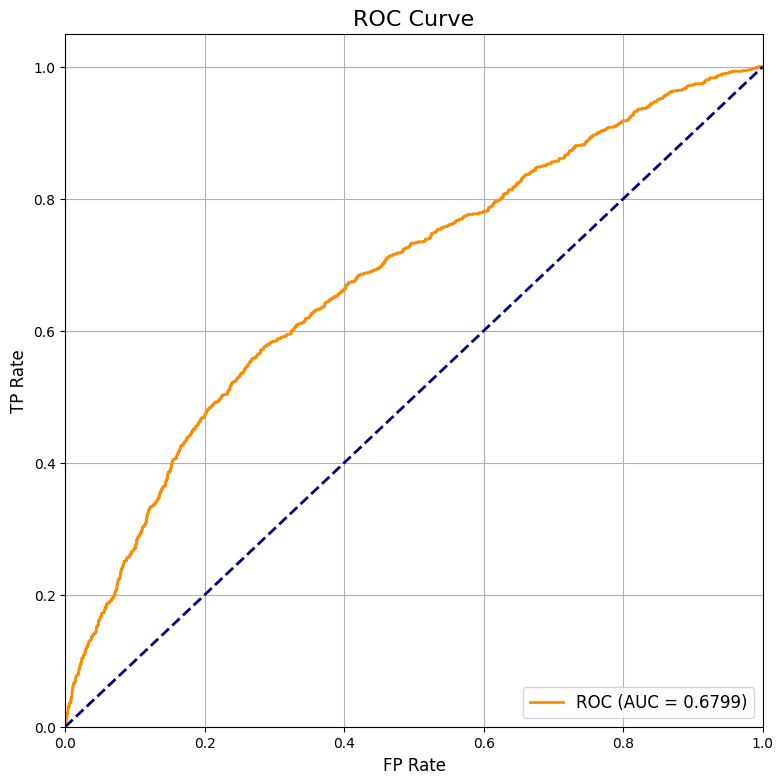

Площадь  ROC-кривой: 0.6799


In [49]:

y_pred_proba = model.predict_proba(X_test)[:, 1]


auc_score = roc_auc_score(y_test, y_pred_proba)


fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)


plt.figure(figsize=(9, 9))


plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC (AUC = {auc_score:.4f})')

#рисуем линию (соответствует случайному угаданию)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP Rate', fontsize=12)
plt.ylabel('TP Rate', fontsize=12)
plt.title('ROC Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

print(f"Площадь  ROC-кривой: {auc_score:.4f}")

## Обучим модель только на эмбеддингах из изображений


Размерность матрицы признаков X: (24774, 512)

Разделяем данные на обучающую (80%) и тестовую (20%) выборки...

Обучаем CatBoostClassifier только на эмбеддингах изображений...
0:	test: 0.5112033	best: 0.5112033 (0)	total: 369ms	remaining: 6m 8s
100:	test: 0.5398888	best: 0.5429815 (59)	total: 40.6s	remaining: 6m 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5429814868
bestIteration = 59

Shrink model to first 60 iterations.

Оцениваем качество модели, обученной только на изображениях

--- Отчет по классификации 
              precision    recall  f1-score   support

           0       0.82      0.51      0.63      3941
           1       0.22      0.55      0.32      1014

    accuracy                           0.52      4955
   macro avg       0.52      0.53      0.47      4955
weighted avg       0.69      0.52      0.57      4955

ROC-AUC(только изображения): 0.5430
Строим график ROC-AUC...


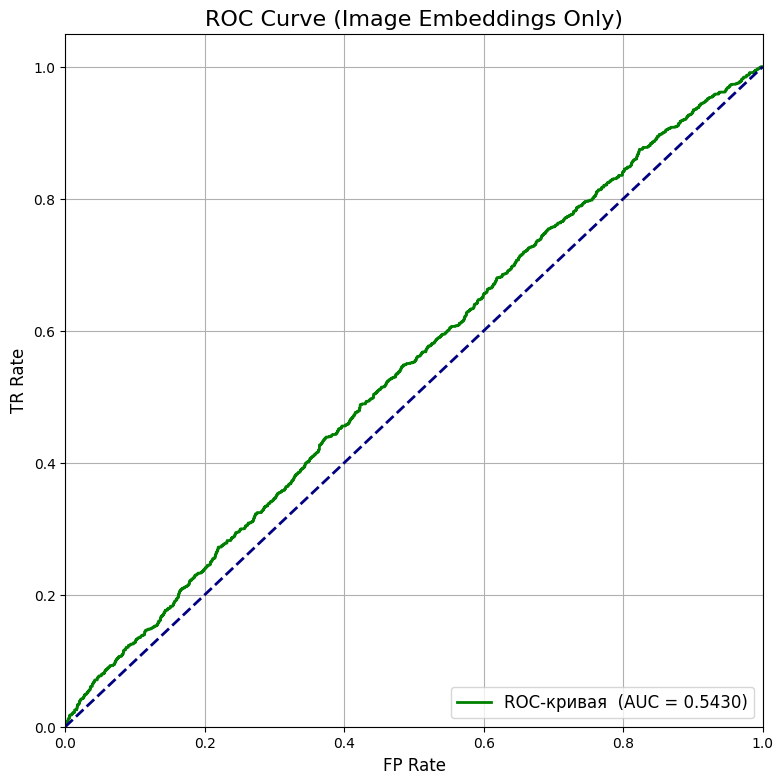

In [50]:
df_image_model = df.copy()

df_image_model.dropna(subset=['image_embedding'], inplace=True)

X_image = pd.DataFrame(
    df_image_model['image_embedding'].tolist(),
    index=df_image_model.index
)
X_image.columns = [f'img_emb_{i}' for i in range(X_image.shape[1])]
y_image = df_image_model['target']

print(f"Размерность матрицы признаков X: {X_image.shape}")

print("\nРазделяем данные на обучающую (80%) и тестовую (20%) выборки...")
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(
    X_image, y_image,
    test_size=0.2,
    random_state=42,
    stratify=y_image 
)
print("\nОбучаем CatBoostClassifier только на эмбеддингах изображений...")

model_image_only = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.0005,
    #auto_class_weights='Balanced',
    l2_leaf_reg=0,
    random_state=42,
    verbose=100,
    devices='gpu',
    loss_function='Focal:focal_alpha=0.8;focal_gamma=2.0',   
    eval_metric='AUC',
    
    bootstrap_type='Bernoulli',
    subsample=0.9,
    depth = 8
)


model_image_only.fit(
    X_train_img, y_train_img,
    eval_set=(X_test_img, y_test_img),
    early_stopping_rounds=50
)



print("\nОцениваем качество модели, обученной только на изображениях")
y_pred_img = model_image_only.predict(X_test_img)
y_pred_proba_img = model_image_only.predict_proba(X_test_img)[:, 1]

print("\n--- Отчет по классификации ")
print(classification_report(y_test_img, y_pred_img))

auc_score_img = roc_auc_score(y_test_img, y_pred_proba_img)
print(f"ROC-AUC(только изображения): {auc_score_img:.4f}")


print("Строим график ROC-AUC...")
fpr_img, tpr_img, _ = roc_curve(y_test_img, y_pred_proba_img)

plt.figure(figsize=(9, 9))
plt.plot(fpr_img, tpr_img, color='green', lw=2, 
         label=f'ROC-кривая  (AUC = {auc_score_img:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP Rate', fontsize=12)
plt.ylabel('TR Rate', fontsize=12)
plt.title('ROC Curve (Image Embeddings Only)', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

## обучаем используем первоначальные + графические признаки


Заполняем пропуски в числовых колонках медианой по категориям...
Размерность итоговой матрицы признаков X: (24774, 1539)

Разделяем данные на обучающую (80%) и тестовую (20%) выборки...

Обучаем CatBoostClassifier на ВСЕХ признаках...


C:\Users\Alex\AppData\Local\Temp\ipykernel_9120\1844966908.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_full[col].fillna(category_medians, inplace=True)


0:	test: 0.6288970	best: 0.6288970 (0)	total: 1.14s	remaining: 18m 57s
100:	test: 0.6754018	best: 0.6755749 (77)	total: 1m 44s	remaining: 15m 27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6767850949
bestIteration = 119

Shrink model to first 120 iterations.

Оцениваем качество финальной модели...

--- Отчет по классификации (ВСЕ признаки) ---
              precision    recall  f1-score   support

           0       0.86      0.74      0.80      3941
           1       0.35      0.55      0.43      1014

    accuracy                           0.70      4955
   macro avg       0.61      0.64      0.61      4955
weighted avg       0.76      0.70      0.72      4955

ROC-AUC Score (ВСЕ признаки): 0.6768


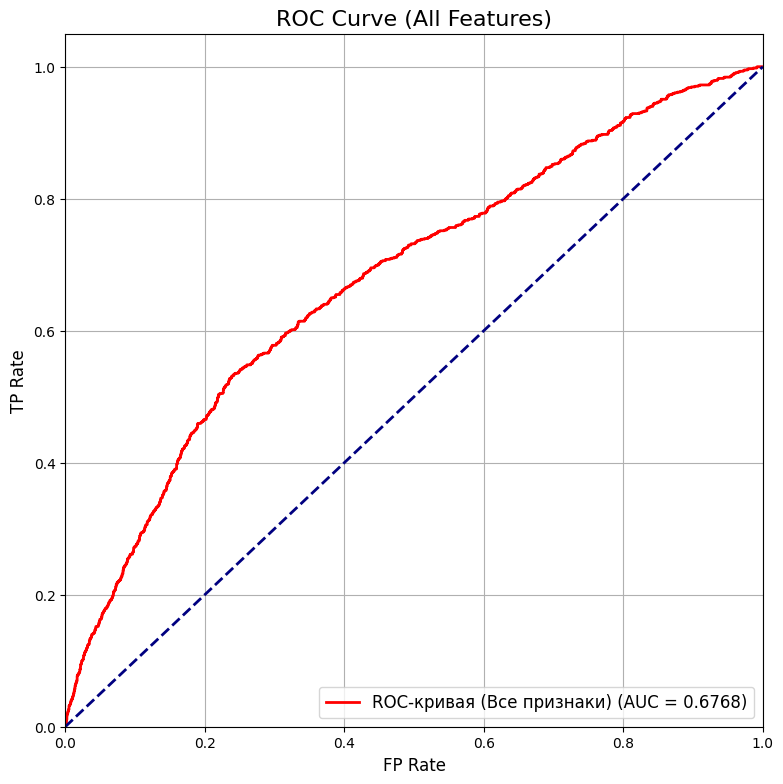

In [53]:

df_full = df.copy()

df_full.dropna(subset=['image_embedding', 'text_embedding', 'target'], inplace=True)

base_features = ['brand', 'sales_price', 'category']
X_tabular = df_full[base_features]

X_image_embeddings = pd.DataFrame(
    df_full['image_embedding'].tolist(),
    index=df_full.index
).add_prefix('img_emb_')

X_text_embeddings = pd.DataFrame(
    df_full['text_embedding'].tolist(),
    index=df_full.index
).add_prefix('txt_emb_')

X_full = pd.concat([X_tabular, X_image_embeddings, X_text_embeddings], axis=1)


y_full = df_full['target']


categorical_features = ['brand', 'category']


print("\nЗаполняем пропуски в числовых колонках медианой по категориям...")
for col in ['sales_price']:
    if X_full[col].isnull().any():
        category_medians = X_full.groupby('category')[col].transform('median')
        X_full[col].fillna(category_medians, inplace=True)

print(f"Размерность итоговой матрицы признаков X: {X_full.shape}")

print("\nРазделяем данные на обучающую (80%) и тестовую (20%) выборки...")
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full)


print("\nОбучаем CatBoostClassifier на ВСЕХ признаках...")

model_full = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.0005,
    #auto_class_weights='Balanced',
    l2_leaf_reg=0,
    random_state=42,
    verbose=100,
    devices='gpu',
    loss_function='Focal:focal_alpha=0.8;focal_gamma=2.0',   
    eval_metric='AUC',
    
    bootstrap_type='Bernoulli',
    subsample=0.9,
    depth = 8
)

model_full.fit(
    X_train_full, y_train_full,
    cat_features=categorical_features,
    eval_set=(X_test_full, y_test_full),
    early_stopping_rounds=50
)


print("\nОцениваем качество финальной модели...")
y_pred_full = model_full.predict(X_test_full)
y_pred_proba_full = model_full.predict_proba(X_test_full)[:, 1]

print("\n--- Отчет по классификации (ВСЕ признаки) ---")
print(classification_report(y_test_full, y_pred_full))

auc_score_full = roc_auc_score(y_test_full, y_pred_proba_full)
print(f"ROC-AUC Score (ВСЕ признаки): {auc_score_full:.4f}")


fpr_full, tpr_full, _ = roc_curve(y_test_full, y_pred_proba_full)

plt.figure(figsize=(9, 9))
plt.plot(fpr_full, tpr_full, color='red', lw=2, 
         label=f'ROC-кривая (Все признаки) (AUC = {auc_score_full:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP Rate', fontsize=12)
plt.ylabel('TP Rate', fontsize=12)
plt.title('ROC Curve (All Features)', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

Отображаем изображения для топ-2 категорий: WomensKurtasKurtis и MensT_Shirts


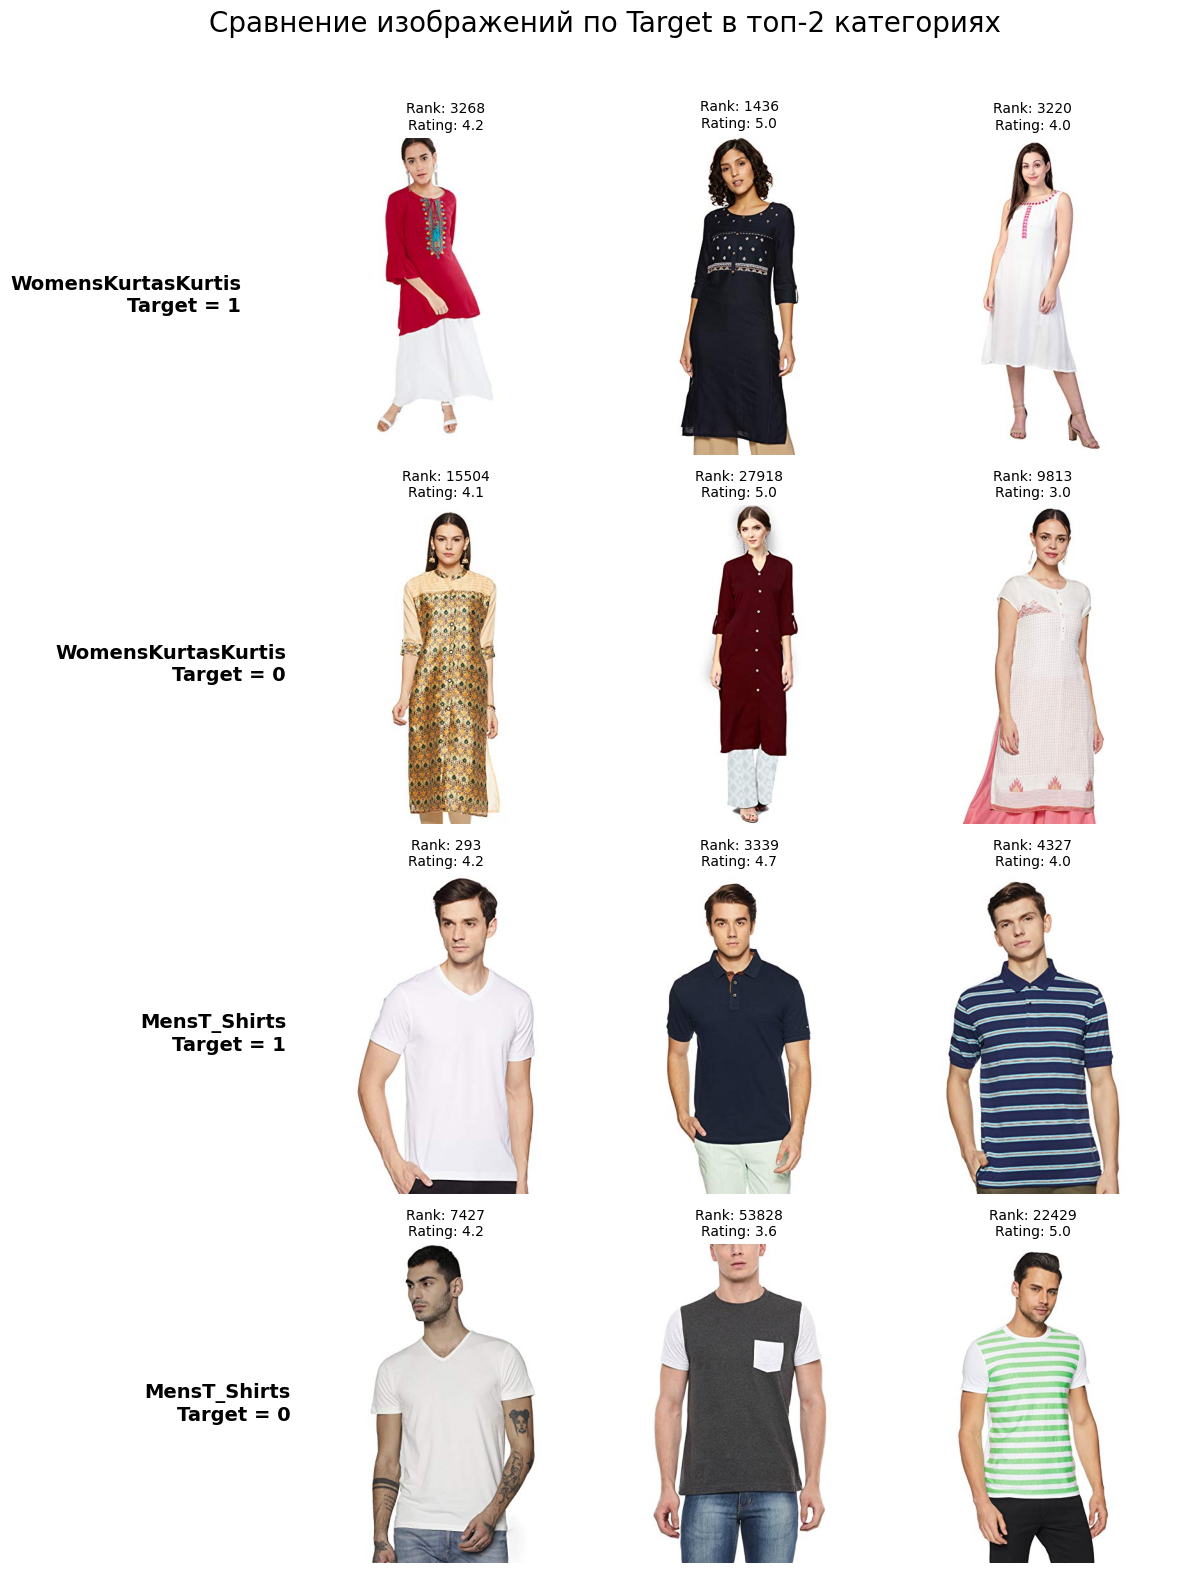

In [7]:
# визуально cравним изображения по Target в топ-2 категориях (визуально таргеты практически невозможно отличить)
top_2_categories = df['category'].value_counts().head(2).index.tolist()
print(f"Отображаем изображения для топ-2 категорий: {top_2_categories[0]} и {top_2_categories[1]}")


df_filtered = df[df['category'].isin(top_2_categories)].copy()

IMAGE_DIR = "image"
def get_image_path(row):
    try:
        uniq_id = row['uniq_id']
        image_url = row['medium']
        file_extension = os.path.splitext(str(image_url))[1] or ".jpg"
        return os.path.join(IMAGE_DIR, f"{uniq_id}{file_extension}")
    except Exception:
        return None

df_filtered['image_path'] = df_filtered.apply(get_image_path, axis=1)
df_filtered.dropna(subset=['image_path', 'target'], inplace=True)
df_filtered['target'] = df_filtered['target'].astype(int)

fig, axes = plt.subplots(4, 3, figsize=(12, 16))
fig.suptitle('Сравнение изображений по Target в топ-2 категориях', fontsize=20)

labels_to_show = [1, 0]

for cat_idx, category in enumerate(top_2_categories):
    for label_idx, target_label in enumerate(labels_to_show):
        
        
        plot_row = cat_idx * 2 + label_idx
        
        
        df_subset = df_filtered[
            (df_filtered['category'] == category) & 
            (df_filtered['target'] == target_label)
        ]
        
       
        num_samples = min(3, len(df_subset))
        if num_samples > 0:
            samples = df_subset.sample(num_samples, random_state=42)
        else:
            samples = pd.DataFrame() 

     
        for col_idx, (index, row_data) in enumerate(samples.iterrows()):
            ax = axes[plot_row, col_idx]
            image_path = row_data['image_path']
            
            try:
                if os.path.exists(image_path):
                    img = Image.open(image_path)
                    ax.imshow(img)
                    title_text = f"Rank: {int(row_data['rank'])}\nRating: {row_data['rating']}"
                    ax.set_title(title_text, fontsize=10)
                else:
                    ax.text(0.5, 0.5, 'Файл\nне найден', ha='center', va='center')
            except Exception:
                ax.text(0.5, 0.5, 'Ошибка\nзагрузки', ha='center', va='center')
            
            ax.axis('off')
            
        
        axes[plot_row, 0].text(-0.15, 0.5, f'{category}\nTarget = {target_label}', 
                               transform=axes[plot_row, 0].transAxes, 
                               fontsize=14, va='center', ha='right', weight='bold')


for row in range(4):
    for col in range(3):
        if not axes[row, col].images:
            axes[row, col].axis('off')


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## обучим модели только для MensT_Shirts (топ-2 среди категорий)

Отбираем 2 самые популярные категории...
Топ-2 категории: ['MensT_Shirts']
Оставляем 3373 строк, относящихся к этим категориям.

Подготавливаем признаки: объединяем табличные данные и текстовые эмбеддинги...


C:\Users\Alex\AppData\Local\Temp\ipykernel_1476\1791544112.py:43: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





Размерность матрицы признаков X: (3373, 1027)

Обучаем CatBoostClassifier на текстовых и табличных данных (топ-2 категории)...
0:	test: 0.6525377	best: 0.6525377 (0)	total: 1.31s	remaining: 21m 47s
100:	test: 0.7709396	best: 0.7731070 (52)	total: 1m 30s	remaining: 13m 25s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7731069959
bestIteration = 52

Shrink model to first 53 iterations.

Оцениваем качество модели...
ROC-AUC (Текст+Таблицы, Топ-2 категории): 0.7731


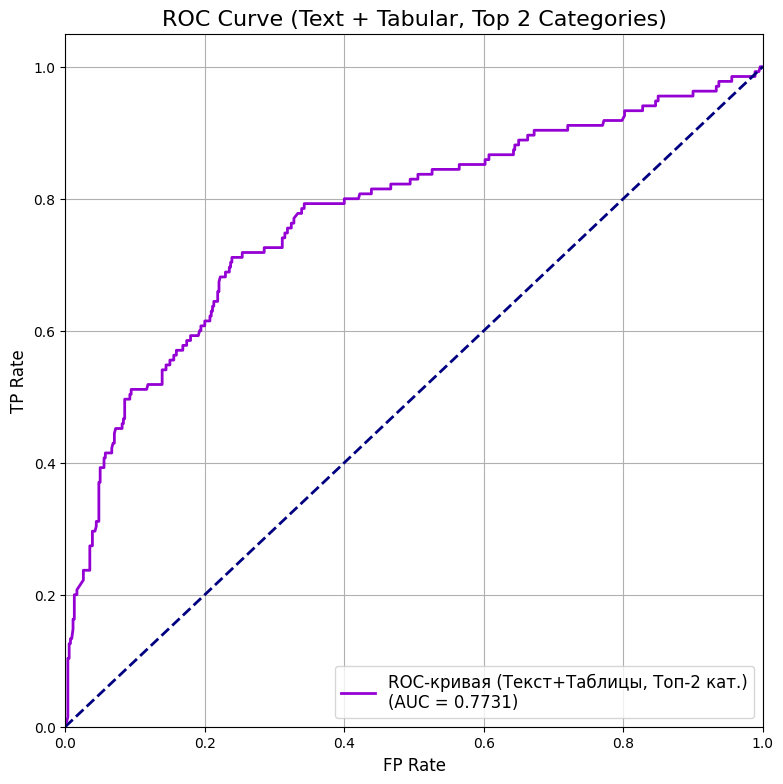

In [28]:


print("Отбираем 2 самые популярные категории...")

top_2_categories = [df['category'].value_counts().index[1]]
print(f"Топ-2 категории: {top_2_categories}")

df_filtered_top2 = df[df['category'].isin(top_2_categories)].copy()
print(f"Оставляем {len(df_filtered_top2)} строк, относящихся к этим категориям.")


df_filtered_top2.dropna(subset=['text_embedding', 'target'], inplace=True)
print("\nПодготавливаем признаки: объединяем табличные данные и текстовые эмбеддинги...")

base_features = ['brand', 'sales_price', 'category']
X_tabular_top2 = df_filtered_top2[base_features]


X_text_emb_top2 = pd.DataFrame(
    df_filtered_top2['text_embedding'].tolist(),
    index=df_filtered_top2.index
).add_prefix('txt_emb_')

X_top2_txt = pd.concat([X_tabular_top2, X_text_emb_top2], axis=1)
y_top2_txt = df_filtered_top2['target']
categorical_features = ['brand', 'category']


for col in ['sales_price']:
    if X_top2_txt[col].isnull().any():
        category_medians = X_top2_txt.groupby('category')[col].transform('median')
        X_top2_txt[col].fillna(category_medians, inplace=True)

print(f"Размерность матрицы признаков X: {X_top2_txt.shape}")



X_train_txt_top2, X_test_txt_top2, y_train_txt_top2, y_test_txt_top2 = train_test_split(
    X_top2_txt, y_top2_txt, test_size=0.2, random_state=42, stratify=y_top2_txt
)

print("\nОбучаем CatBoostClassifier на текстовых и табличных данных (топ-2 категории)...")
model_text_top2 = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.0005,
    l2_leaf_reg=0,
    random_state=42,
    verbose=100,
    devices='GPU',
    loss_function='Focal:focal_alpha=0.8;focal_gamma=2.0',   
    eval_metric='AUC',
    bootstrap_type='Bernoulli',
    subsample=0.9,
    depth=8
)


model_text_top2.fit(
    X_train_txt_top2, y_train_txt_top2,
    cat_features=categorical_features,
    eval_set=(X_test_txt_top2, y_test_txt_top2),
    early_stopping_rounds=50
)


print("\nОцениваем качество модели...")
y_pred_proba_txt_top2 = model_text_top2.predict_proba(X_test_txt_top2)[:, 1]
auc_score_txt_top2 = roc_auc_score(y_test_txt_top2, y_pred_proba_txt_top2)
print(f"ROC-AUC (Текст+Таблицы, Топ-2 категории): {auc_score_txt_top2:.4f}")

fpr_txt_top2, tpr_txt_top2, _ = roc_curve(y_test_txt_top2, y_pred_proba_txt_top2)

plt.figure(figsize=(9, 9))
plt.plot(fpr_txt_top2, tpr_txt_top2, color='darkviolet', lw=2, 
         label=f'ROC-кривая (Текст+Таблицы, Топ-2 кат.)\n(AUC = {auc_score_txt_top2:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP Rate', fontsize=12)
plt.ylabel('TP Rate', fontsize=12)
plt.title('ROC Curve (Text + Tabular, Top 2 Categories)', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

Отбираем 2 самые популярные категории...
Топ-2 категории: ['MensT_Shirts']
Оставляем 3373 строк, относящихся к этим категориям.

Подготавливаем признаки: используем только эмбеддинги изображений...
Размерность матрицы признаков X: (3373, 512)

Разделяем данные на обучающую (80%) и тестовую (20%) выборки...

Обучаем CatBoostClassifier...
0:	test: 0.5689095	best: 0.5689095 (0)	total: 586ms	remaining: 9m 45s
100:	test: 0.6688615	best: 0.6688615 (100)	total: 47.7s	remaining: 7m 4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6733607682
bestIteration = 127

Shrink model to first 128 iterations.

Оцениваем качество модели...

--- Отчет по классификации (Изображения, Топ-2 категории) ---
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       540
           1       0.36      0.45      0.40       135

    accuracy                           0.73       675
   macro avg       0.60      0.62      0.61       675
weighted avg   

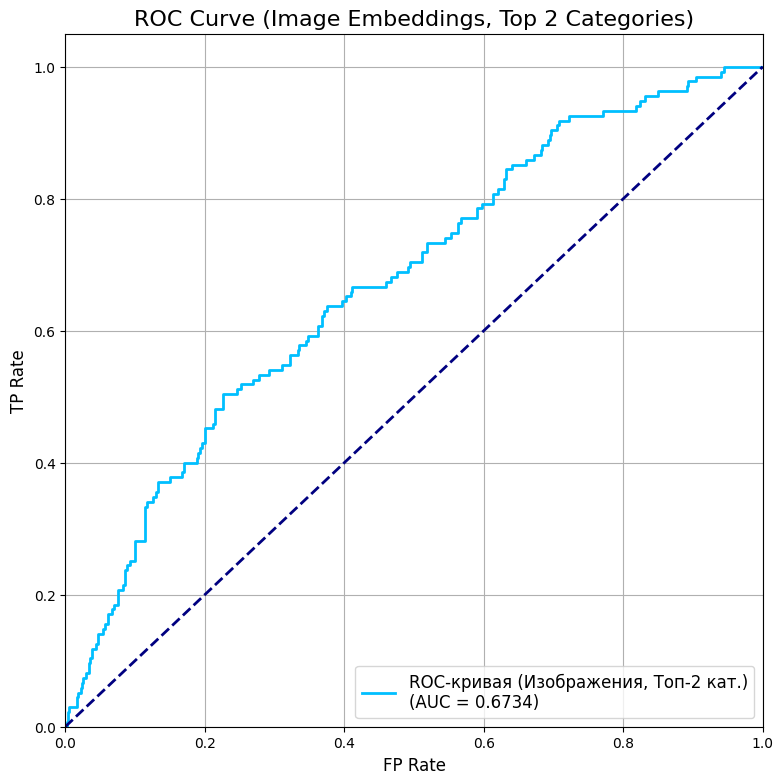

In [29]:

df = df_full.copy()

top_2_categories = [df['category'].value_counts().index[1]]
print(f"Топ-2 категории: {top_2_categories}")

df_filtered_top2 = df[df['category'].isin(top_2_categories)].copy()
print(f"Оставляем {len(df_filtered_top2)} строк, относящихся к этим категориям.")

df_filtered_top2.dropna(subset=['image_embedding'], inplace=True) 

print("\nПодготавливаем признаки: используем только эмбеддинги изображений...")
X_image_top2 = pd.DataFrame(
    df_filtered_top2['image_embedding'].tolist(), 
    index=df_filtered_top2.index
)
X_image_top2.columns = [f'img_emb_{i}' for i in range(X_image_top2.shape[1])]
y_image_top2 = df_filtered_top2['target']

print(f"Размерность матрицы признаков X: {X_image_top2.shape}")

print("\nРазделяем данные на обучающую (80%) и тестовую (20%) выборки...")
X_train_img_top2, X_test_img_top2, y_train_img_top2, y_test_img_top2 = train_test_split(
    X_image_top2, y_image_top2,
    test_size=0.2,
    random_state=42,
    stratify=y_image_top2
)

print("\nОбучаем CatBoostClassifier...")


model_image_top2 = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.0005,
    l2_leaf_reg=0,
    random_state=42,
    verbose=100,
    devices='GPU', 
    loss_function='Focal:focal_alpha=0.8;focal_gamma=2.0',   
    eval_metric='AUC',
    bootstrap_type='Bernoulli',
    subsample=0.9,
    depth=8
)


model_image_top2.fit(
    X_train_img_top2, y_train_img_top2,
    eval_set=(X_test_img_top2, y_test_img_top2),
    early_stopping_rounds=50
)

print("\nОцениваем качество модели...")
y_pred_img_top2 = model_image_top2.predict(X_test_img_top2)
y_pred_proba_img_top2 = model_image_top2.predict_proba(X_test_img_top2)[:, 1]

print("\n--- Отчет по классификации (Изображения, Топ-2 категории) ---")
print(classification_report(y_test_img_top2, y_pred_img_top2))

auc_score_img_top2 = roc_auc_score(y_test_img_top2, y_pred_proba_img_top2)
print(f"ROC-AUC (Изображения, Топ-2 категории): {auc_score_img_top2:.4f}")


fpr_img_top2, tpr_img_top2, _ = roc_curve(y_test_img_top2, y_pred_proba_img_top2)

plt.figure(figsize=(9, 9))
plt.plot(fpr_img_top2, tpr_img_top2, color='deepskyblue', lw=2, 
         label=f'ROC-кривая (Изображения, Топ-2 кат.)\n(AUC = {auc_score_img_top2:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP Rate', fontsize=12)
plt.ylabel('TP Rate', fontsize=12)
plt.title('ROC Curve (Image Embeddings, Top 2 Categories)', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

Отбираем 2 самые популярные категории...
Топ-2 категории: ['MensT_Shirts']

Количество строк до фильтрации: 24774
Количество строк после фильтрации (топ-2 категории): 3373
Подготавливаем признаки для отфильтрованных данных...


C:\Users\Alex\AppData\Local\Temp\ipykernel_1476\1082133839.py:51: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





Размерность итоговой матрицы признаков X: (3373, 1539)

Обучаем CatBoostClassifier на данных из топ-2 категорий...
0:	test: 0.6151440	best: 0.6151440 (0)	total: 1.2s	remaining: 20m 1s
100:	test: 0.7675309	best: 0.7692455 (95)	total: 1m 49s	remaining: 16m 18s
200:	test: 0.7768999	best: 0.7778052 (189)	total: 3m 37s	remaining: 14m 24s
300:	test: 0.7874486	best: 0.7875857 (299)	total: 5m 28s	remaining: 12m 42s
400:	test: 0.7908505	best: 0.7908505 (400)	total: 7m 17s	remaining: 10m 53s
500:	test: 0.7917833	best: 0.7928532 (465)	total: 9m 6s	remaining: 9m 4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7928532236
bestIteration = 465

Shrink model to first 466 iterations.

Оцениваем качество модели для топ-2 категорий...
ROC-AUC Score (топ-2 категории): 0.7929


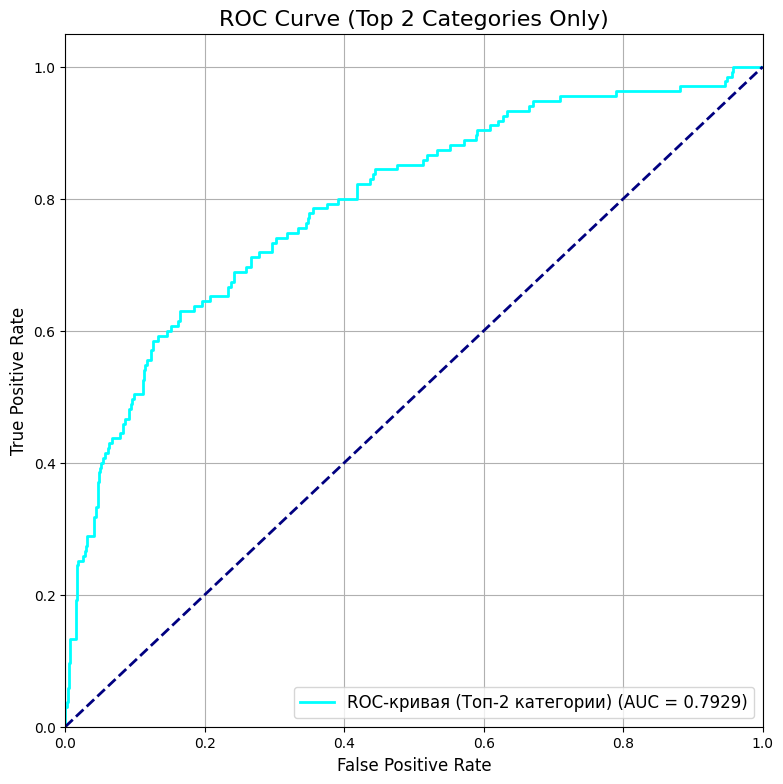

In [30]:

df_full = df.copy()

top_2_categories = [df['category'].value_counts().index[1]]
print(f"Топ-2 категории: {top_2_categories}")

df_top2 = df_full[df_full['category'].isin(top_2_categories)].copy()

print(f"\nКоличество строк до фильтрации: {len(df_full)}")
print(f"Количество строк после фильтрации (топ-2 категории): {len(df_top2)}")

df_top2.dropna(subset=['image_embedding', 'text_embedding', 'target'], inplace=True)
print("Подготавливаем признаки для отфильтрованных данных...")

base_features = ['brand', 'sales_price',  'category']
X_tabular_top2 = df_top2[base_features]

X_image_emb_top2 = pd.DataFrame(df_top2['image_embedding'].tolist(), index=df_top2.index).add_prefix('img_emb_')

X_text_emb_top2 = pd.DataFrame(df_top2['text_embedding'].tolist(), index=df_top2.index).add_prefix('txt_emb_')

X_top2 = pd.concat([X_tabular_top2, X_image_emb_top2, X_text_emb_top2], axis=1)
y_top2 = df_top2['target']
categorical_features = ['brand', 'category']

for col in ['sales_price']:
    if X_top2[col].isnull().any():
        category_medians = X_top2.groupby('category')[col].transform('median')
        X_top2[col].fillna(category_medians, inplace=True)

print(f"Размерность итоговой матрицы признаков X: {X_top2.shape}")

X_train_top2, X_test_top2, y_train_top2, y_test_top2 = train_test_split(
    X_top2, y_top2, test_size=0.2, random_state=42, stratify=y_top2
)

print("\nОбучаем CatBoostClassifier на данных из топ-2 категорий...")
model_top2 = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.0005,
    #auto_class_weights='Balanced',
    l2_leaf_reg=0,
    random_state=42,
    verbose=100,
    devices='gpu',
    loss_function='Focal:focal_alpha=0.8;focal_gamma=2.0',   
    eval_metric='AUC',
    
    bootstrap_type='Bernoulli',
    subsample=0.9,
    depth = 8
)


model_top2.fit(
    X_train_top2, y_train_top2,
    cat_features=categorical_features,
    eval_set=(X_test_top2, y_test_top2),
    early_stopping_rounds=50
)

print("\nОцениваем качество модели для топ-2 категорий...")
y_pred_proba_top2 = model_top2.predict_proba(X_test_top2)[:, 1]
auc_score_top2 = roc_auc_score(y_test_top2, y_pred_proba_top2)
print(f"ROC-AUC Score (топ-2 категории): {auc_score_top2:.4f}")

fpr_top2, tpr_top2, _ = roc_curve(y_test_top2, y_pred_proba_top2)

plt.figure(figsize=(9, 9))
plt.plot(fpr_top2, tpr_top2, color='cyan', lw=2, 
         label=f'ROC-кривая (Топ-2 категории) (AUC = {auc_score_top2:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve (Top 2 Categories Only)', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

## применим k-means и посмотрим umap проекцию на 2D для графических эмбеддингов

In [37]:
df_full = df.copy()

top_2nd_category = df_full['category'].value_counts().index[1]
print(f"Используем данные только из категории: '{top_2nd_category}'")

df_filtered = df_full[df_full['category'] == top_2nd_category].copy()
df_filtered.dropna(subset=['image_embedding', 'target'], inplace=True)
print(f"Количество строк для анализа: {len(df_filtered)}")

X_embeddings = np.vstack(df_filtered['image_embedding'].values)

print(f"\nВыполняем кластеризацию K-Means с k=2...")
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto').fit(X_embeddings)
df_filtered['image_cluster'] = kmeans.labels_



print("\n--- Анализ результатов ---")

crosstab = pd.crosstab(df_filtered['image_cluster'], df_filtered['target'])
print("Сводная таблица (image_cluster vs target):")
print(crosstab)

ari_score = adjusted_rand_score(df_filtered['target'], df_filtered['image_cluster'])
print(f"\nAdjusted Rand Index (ARI): {ari_score:.4f}")
print("(Чем ближе к 1.0, тем лучше кластеры совпадают с target)")




Отбираем вторую по популярности категорию...
Используем данные только из категории: 'MensT_Shirts'
Количество строк для анализа: 3373

Выполняем кластеризацию K-Means с k=2...

--- Анализ результатов ---
Сводная таблица (image_cluster vs target):
target            0    1
image_cluster           
0              1454  450
1              1244  225

Adjusted Rand Index (ARI): -0.0062
(Чем ближе к 1.0, тем лучше кластеры совпадают с target)


In [ ]:

print("\nСнижаем размерность до 2D для визуального сравнения...")
reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = reducer.fit_transform(X_embeddings)

df_vis = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
df_vis['K-Means кластер'] = df_filtered['image_cluster'].astype(str).values
df_vis['Реальный Target'] = df_filtered['target'].astype(str).values
df_vis['product_name'] = df_filtered['product_name'].values


fig1 = px.scatter(
    df_vis, x='x', y='y', color='K-Means кластер',
    hover_data=['product_name'],
    title=f'Результат K-Means кластеризации (k=2) для категории "{top_2nd_category}"'
)
fig1.show()


fig2 = px.scatter(
    df_vis, x='x', y='y', color='Реальный Target',
    hover_data=['product_name'],
    title=f'Реальное распределение Target для категории "{top_2nd_category}"'
)
fig2.show()


Снижаем размерность до 2D для визуального сравнения...


h:\python\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
# построим 3D UMAP для графических эмбеддингов (для примера возьмем 5 кластеров, можно применить метод локктя для оптимального количества кластеров)
df_full = df.copy()


top_1_category = df_full['category'].value_counts().index[1]
df_top1 = df_full[df_full['category'] == top_1_category].copy()


df_top1['original_index'] = df_top1.index

df_top1.dropna(subset=['image_embedding', 'target'], inplace=True)


X_embeddings_top1 = np.vstack(df_top1['image_embedding'].values)


OPTIMAL_K_TOP1 = 5 
kmeans_top1 = KMeans(n_clusters=OPTIMAL_K_TOP1, random_state=42, n_init='auto').fit(X_embeddings_top1)
df_top1['image_cluster'] = kmeans_top1.labels_

print("Снижаем размерность эмбеддингов до 3D с помощью UMAP...")
reducer_3d = umap.UMAP(n_components=3, random_state=42)
embeddings_3d = reducer_3d.fit_transform(X_embeddings_top1)


df_3d_vis = pd.DataFrame(embeddings_3d, columns=['x', 'y', 'z'])
df_3d_vis['cluster'] = kmeans_top1.labels_.astype(str)
df_3d_vis['product_name'] = df_top1['product_name'].values


df_3d_vis['target'] = df_top1['target'].values
df_3d_vis['original_index'] = df_top1['original_index'].values 

print("\nСтроим интерактивный 3D-график...")

fig = px.scatter_3d(
    df_3d_vis,
    x='x',
    y='y',
    z='z',
    color='cluster',
    
    hover_data=['product_name', 'target', 'original_index'], 
    title=f'3D-визуализация кластеров для категории "{top_1_category}" (Target и Index)'
)

fig.update_layout(
    width=900,
    height=800,
    margin=dict(l=0, r=0, b=0, t=40)
)
fig.update_traces(marker=dict(size=3.5, opacity=0.8))

fig.show()

Снижаем размерность эмбеддингов до 3D с помощью UMAP...


h:\python\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.




Строим интерактивный 3D-график...


In [ ]:

OPTIMAL_K_TOP1 = 5 
print(f"\nВыполняем кластеризацию с k={OPTIMAL_K_TOP1}...")

kmeans_top1 = KMeans(n_clusters=OPTIMAL_K_TOP1, random_state=42, n_init='auto').fit(X_embeddings_top1)
df_top1['image_cluster'] = kmeans_top1.labels_


print(f"\nАнализируем распределение Target по кластерам для категории '{top_1_category}'...")

crosstab_norm_top1 = pd.crosstab(df_top1['image_cluster'], df_top1['target'], normalize='index')
crosstab_norm_top1 = crosstab_norm_top1.sort_values(1, ascending=False)
print("\nДоля каждого класса внутри кластера:")
print(crosstab_norm_top1)

bar_fig_top1 = px.bar(
    crosstab_norm_top1, 
    y=1,
    title=f'Доля товаров с Target=1 в каждом кластере (для категории "{top_1_category}")',
    labels={'y': 'Доля Target=1', 'image_cluster': 'Номер кластера'},
    height=500
)
bar_fig_top1.show()



Выполняем кластеризацию с k=5...

Анализируем распределение Target по кластерам для категории 'MensT_Shirts'...

Доля каждого класса внутри кластера:
target                0         1
image_cluster                    
4              0.740088  0.259912
0              0.744604  0.255396
2              0.827839  0.172161
1              0.855528  0.144472
3              0.880658  0.119342
